## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
#!pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user
#!pip install pyzipcode

**Note**:

1. After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab), write the relevant code for the project from the next cell, and run all cells sequentially from the next cell.

2. On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt
import time

# Loading offline uszipcode database
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()

# Finding the unique values of categorical column
# input:
# df -> dataframe
# column_name -> Column/Attribute name
def unique_values(df, column_name):
    column_data_type_name = df.dtypes[column_name].name
    is_numeric = True if column_data_type_name not in ["object", "string"] else False

    if not is_numeric:
        df_unique_value_count = df[column_name].value_counts()
        print("Total unique value {} for attribute {}".format(len(df_unique_value_count.index), column_name))
        
        #printing underline text
        print("\n\033[4m{}\033[0m  \033[4mTotal Count\033[0m".format(column_name))
        print(df_unique_value_count)
        
# Drawing a horizontal line
# Input: 
# length -> number of char/length of a line
def print_horizontal_line(length):
    print("-" * length)





## Loading the dataset

In [3]:
data = pd.read_csv("Loan_Modelling.csv")
df = data.copy()

#label of target attribute to predict
y_colmn = "Personal_Loan"

# 0 -> Not Accepted, 1 -> Accepted of "Personal_Loan" column
# This is useful if a target class has string label other than 0/1
classes = ['0','1']



## Data Overview

* Observations
* Sanity checks

In [4]:
print("Shape {}".format(df.shape))
print("Data set has {} rows and {} columns".format(df.shape[0], df.shape[1]))

Shape (5000, 14)
Data set has 5000 rows and 14 columns


In [5]:
print("Duplicate values")
print("Data set has {} duplicates".format(df.duplicated().sum()))

Duplicate values
Data set has 0 duplicates


In [6]:
print(df.describe().T)

                     count          mean          std      min       25%  \
ID                  5000.0   2500.500000  1443.520003      1.0   1250.75   
Age                 5000.0     45.338400    11.463166     23.0     35.00   
Experience          5000.0     20.104600    11.467954     -3.0     10.00   
Income              5000.0     73.774200    46.033729      8.0     39.00   
ZIPCode             5000.0  93169.257000  1759.455086  90005.0  91911.00   
Family              5000.0      2.396400     1.147663      1.0      1.00   
CCAvg               5000.0      1.937938     1.747659      0.0      0.70   
Education           5000.0      1.881000     0.839869      1.0      1.00   
Mortgage            5000.0     56.498800   101.713802      0.0      0.00   
Personal_Loan       5000.0      0.096000     0.294621      0.0      0.00   
Securities_Account  5000.0      0.104400     0.305809      0.0      0.00   
CD_Account          5000.0      0.060400     0.238250      0.0      0.00   
Online      

In [7]:
df[df['Experience'] < 0][['Experience']].count()

Experience    52
dtype: int64

In [8]:
total_customer_with_zero_mortgage = df[df['Mortgage'] == 0][['Mortgage']].count()
total_customer_with_nonzero_mortgage = df.shape[0] - total_customer_with_zero_mortgage
print("total customer with no mortgage {}".format(total_customer_with_zero_mortgage))
print("total customer with mortgage {}".format(total_customer_with_nonzero_mortgage))

total customer with no mortgage Mortgage    3462
dtype: int64
total customer with mortgage Mortgage    1538
dtype: int64


### Observation
* There are 5000 unique IDs.
* Customers with average age and median is 45 years old.
* Customers have on an average 20 years of experience. Moreover, there were 53 rows with negative Experience.
* Average income of customers aroung 45 thousand dollar and the median is 64 thousand dollar. The majority of the customers fall between 39-98 thousand dollar. It has also outliers.
* ZIPCode provides very little information. However, there is an opertunity to extract geographical information like city/state, etc., from ZIPCode.
* Family is a numeric type but categorical variable as Family size varies from 1-4 in data set.
* Most customer has CCAvg/Average spending on credit in between .7-2.5 K dollar/month with mean 1.93K. It has also outliers.
* Morte than 50% of customers doesn't have any mortgage where average mortgage is near 56K dollar. 3462 customers have no mortgage and 1538 customers have mortgage.
* Other columns/attributes (Education, Personal_Loan, Securities_account, CD_Account, Online, CreditCard) are numeric but categorical.
* Most customer did not accept the personal loan offered in the last campaign.
* Most customer don't have securities account and certificate of deposit with the bank.
* Many customers use internet banking facilities.
* 50% or more customer do not use a credit card issued by any other Bank.

In [9]:
print("Missing value")
print(df.isnull().sum())

Missing value
ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64


### Observation
* Dataset doesn't have any missing value

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [11]:
print("Top 5 rows / Head")
df.head()

Top 5 rows / Head


ID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49    91107       4    1.6          1         0   
1   2   45          19      34    90089       3    1.5          1         0   
2   3   39          15      11    94720       1    1.0          1         0   
3   4   35           9     100    94112       1    2.7          2         0   
4   5   35           8      45    91330       4    1.0          2         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [12]:
print("5 Sample")
df.sample(5)


5 Sample


ID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  \
2010  2011   61          36      41    96001       2    1.5          1   
4489  4490   39          13      21    95518       3    0.2          2   
2640  2641   39          13      81    94309       2    2.8          1   
3940  3941   41          17      53    93727       2    2.5          1   
4312  4313   41          15      93    95616       1    2.8          3   

      Mortgage  Personal_Loan  Securities_Account  CD_Account  Online  \
2010         0              0                   0           0       0   
4489         0              0                   0           0       1   
2640         0              0                   0           0       1   
3940       102              0                   0           0       1   
4312         0              0                   0           0       1   

      CreditCard  
2010           0  
4489           0  
2640           0  
3940           0  
4312           0

### Observation
* There are total 5000 rows and all are unique.
* ID, Age, Experience, Income, ZIPCode, CCAvg, Mortgage are numerical continuous variable/type.
* Family, Education, Personal_Loan, Securities_Account, CD_Account, Online, CreditCard are categorical variable/type.

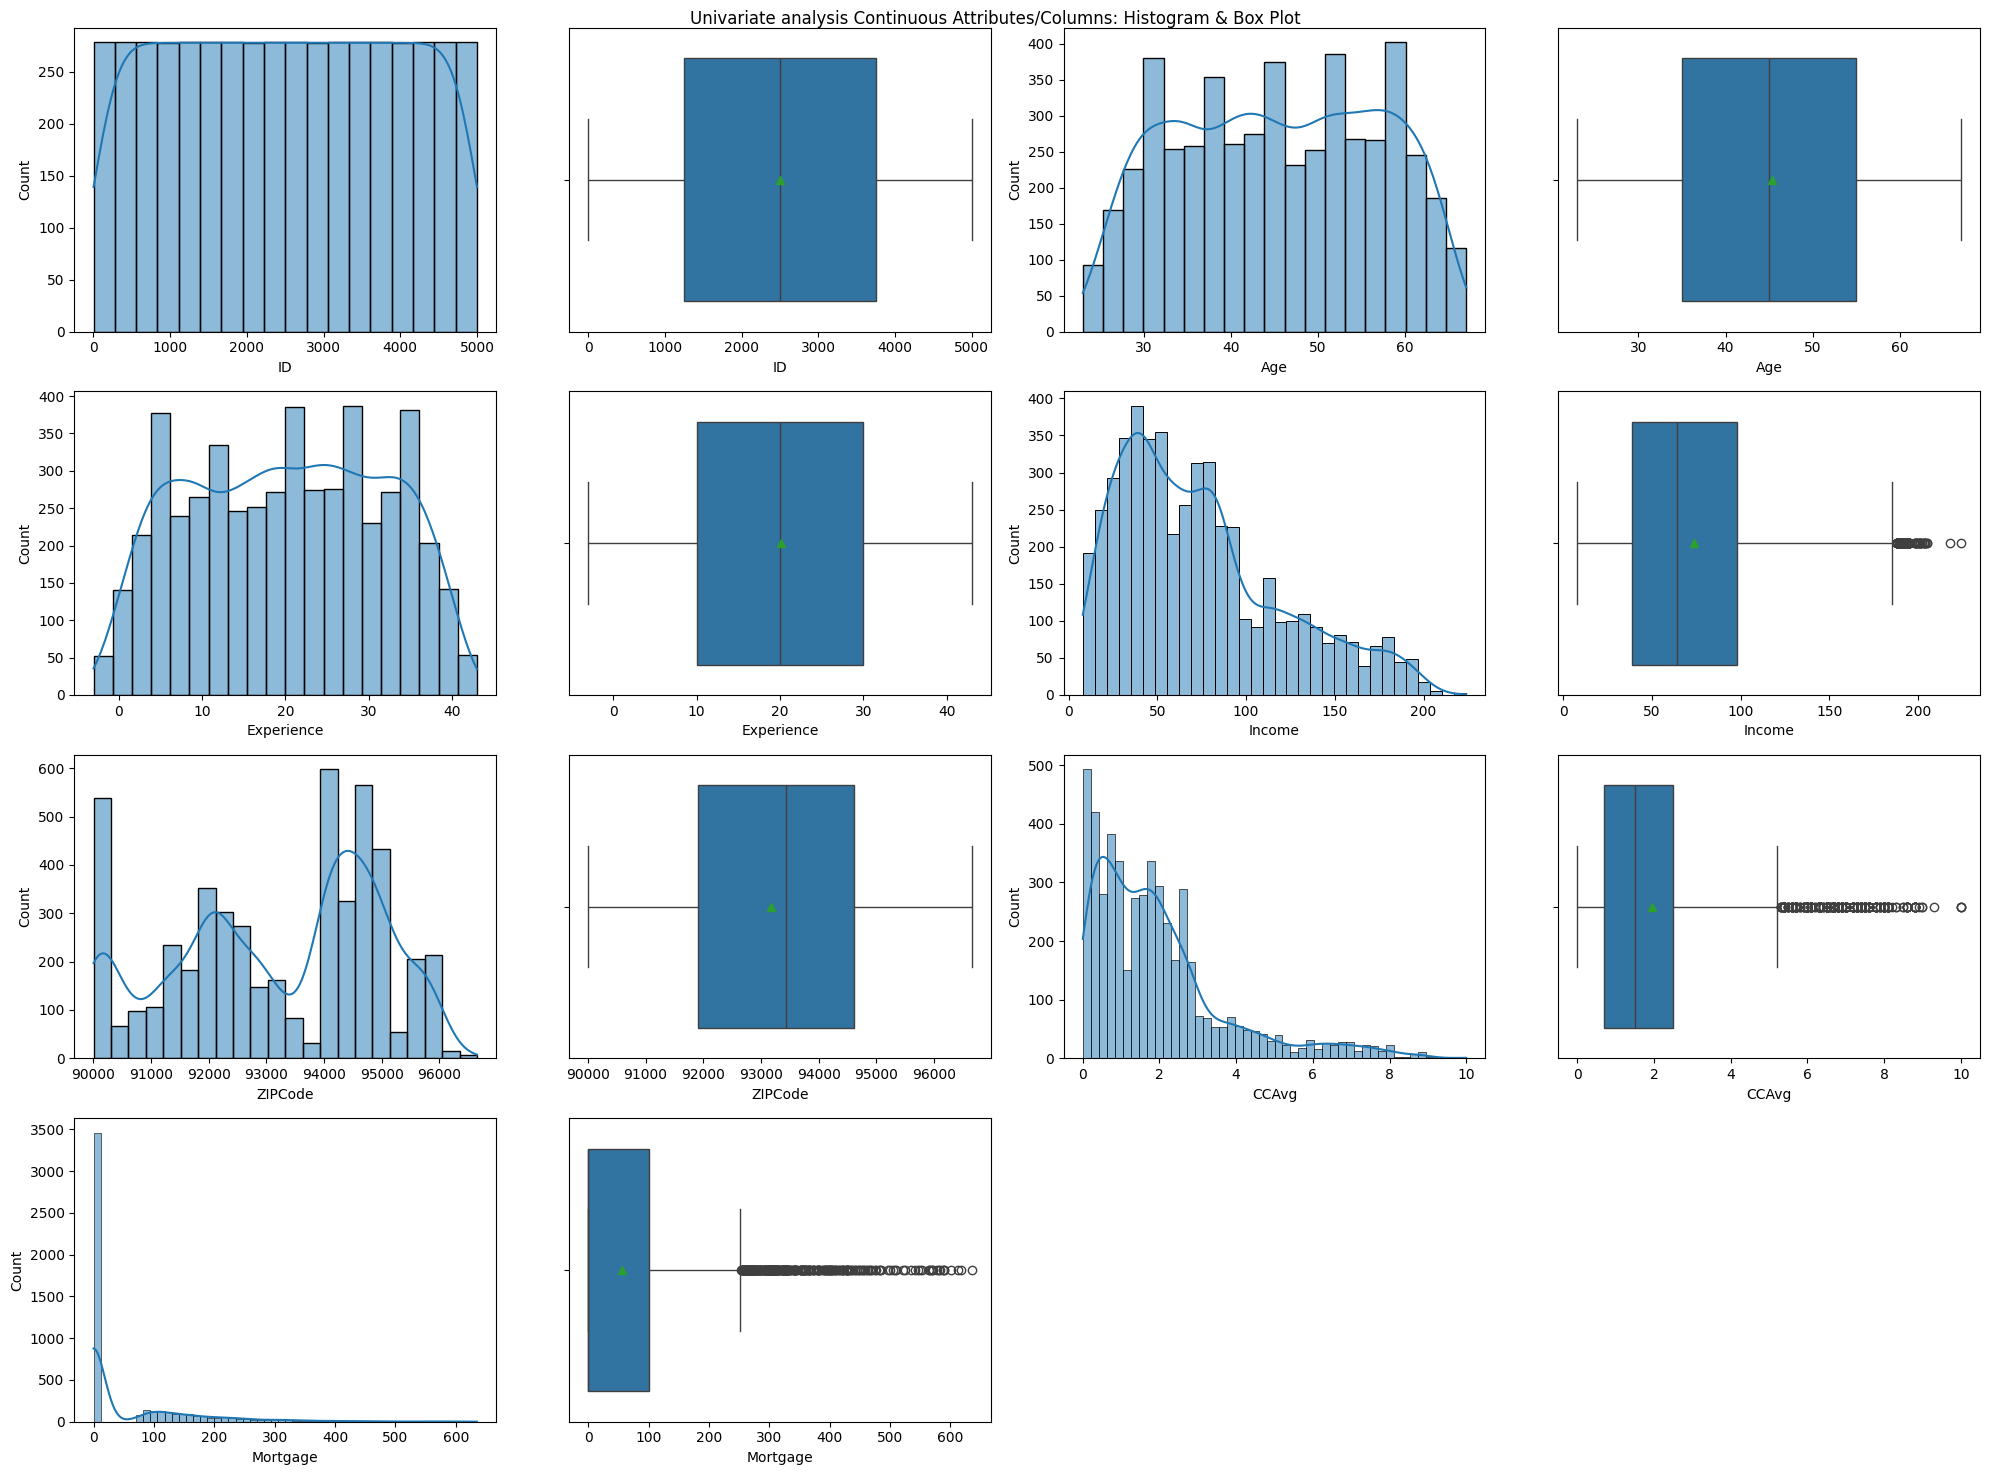

In [13]:
# Common Exploratory Data Analysis
import math

# Count plot for categorical attributes
# input:
# df -> dataframe
# cat_attrs -> List of categorical attributes/Columns
# target_col -> Predicted Column. If this is not None, countplot is drwan for each variable with respect to predicted column
def count_plot(df, cat_attrs, target_col=None):
    plt.figure(figsize=(20, 8))
    for i, col in enumerate(cat_attrs):
        plt.subplot(2, math.ceil(len(cat_attrs)/2), i + 1)
        ax = sns.countplot(data=df, x=col, hue=target_col) 
        for container in ax.containers:
            ax.bar_label(container)
        plt.tight_layout()
        plt.title(col)
    
    plt.show()

# univariate_analysis takes dataframe as input and draw the histogram and box plot
# input:
# df -> dataframe
# cat_attrs -> List of categorical attributes/Columns
# num_row -> now of displaying row
# It draws histogram and boxplot together for each continuous attribute
def univariate_analysis_continuous_attributes(df, cat_attrs, num_row):
    columns = [ x for x in df.select_dtypes(include='number').columns.tolist() if x not in cat_attrs]
    # We will show histogram and box plot together
    num_col = math.ceil(2 * len(columns) / num_row) 
    #print(num_row, num_col)
    fig, axes = plt.subplots(num_row, num_col, figsize=(20, 15))
    fig.suptitle('Univariate analysis Continuous Attributes/Columns: Histogram & Box Plot')
    i = 0
    j = 0
    
    for col in columns:
        if j > num_col - 1:
            j = 0
            i = i + 1
            
        sns.histplot(ax=axes[i, j], data=df, x=col, kde=True)
        sns.boxplot(ax=axes[i, j + 1], data=df, x=col,showmeans=True)
        j = j + 2

    # Iterate through all subplots and remove those without data
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show();

cat_attrs = ["Securities_Account", "CD_Account", "Online", "CreditCard", 'Family', 'Education', 'Personal_Loan']
univariate_analysis_continuous_attributes(df, cat_attrs, 4)

In [14]:
print("Number of customer with no mortgage {}".format(df[df["Mortgage"] == 0][["Mortgage"]].count()))
print("Mortgage after filtering customer with no mortgage")
df[df["Mortgage"] > 0][["Mortgage"]].describe().T

Number of customer with no mortgage Mortgage    3462
dtype: int64
Mortgage after filtering customer with no mortgage


count        mean         std   min    25%    50%    75%    max
Mortgage  1538.0  183.676203  101.361226  75.0  109.0  153.0  227.0  635.0

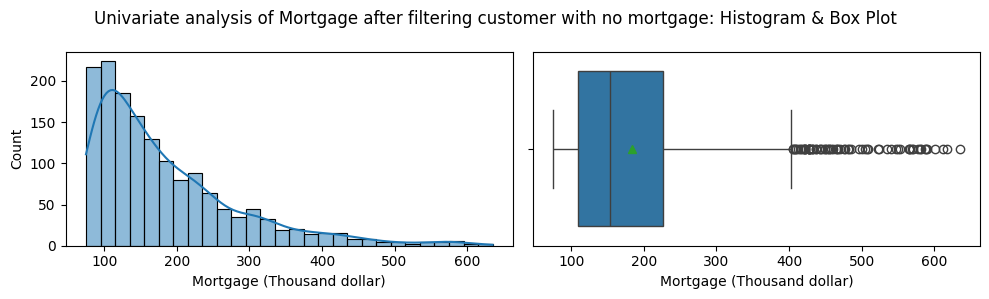

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Univariate analysis of Mortgage after filtering customer with no mortgage: Histogram & Box Plot')
sns.histplot(ax=axes[0], data=df[df["Mortgage"] > 0][["Mortgage"]], x="Mortgage", kde=True)
axes[0].set_xlabel("Mortgage (Thousand dollar)")
sns.boxplot(ax=axes[1], data=df[df["Mortgage"] > 0][["Mortgage"]], x="Mortgage",showmeans=True)
axes[1].set_xlabel("Mortgage (Thousand dollar)")
plt.tight_layout()
plt.show()

### Observation - Continuous Attributes/Columns
* **ID**
     - ID has uniform distribution and has no impact for prediction/classification
* **Age**
     - Age has a distribution with few peaks. However, it's mean and median is same (45 years) with no outlier. 
* **Experience**
     - Experience has a distribution with few peaks. However, it's mean and median is same (20 years) with no outlier. It has 52 entries with negative values. As experience can't be negative, they are wrongly entired.
* **Income**
     - Income has righ skewed distribution with outliers. However, the outlier could give high income information customer and crucial for prediction. So, we will treat it as information and will not filter.
* **ZIPCode**
     - ZIPCode has multi modal distribution and has hardly impact for prediction/classification. However, extracting geolocation information like STATE/CITY could be helpful for prediction
* **CCAvg**
      - CCAvg/Average credit card spending per month has righ skewed distribution with outliers. However, the outlier could give high speding customer information and crucial for prediction. So, we will treat it as information and will not filter.
* **Mortgage**
      - Morte than 50% of customers doesn't have any mortgage where average mortgage is near 56K dollar. 3462 customers have no mortgage and 1538 customers have mortgage. If we exclude 0 mortgage, it has a right skewed distribution with outliers and the mean shifted to near about 190K. It means that average mortgage is near 190K of customers who has a mortgage. However, high mortgage might correlate to the prediction. So, we will treat it as information and will not filter. 


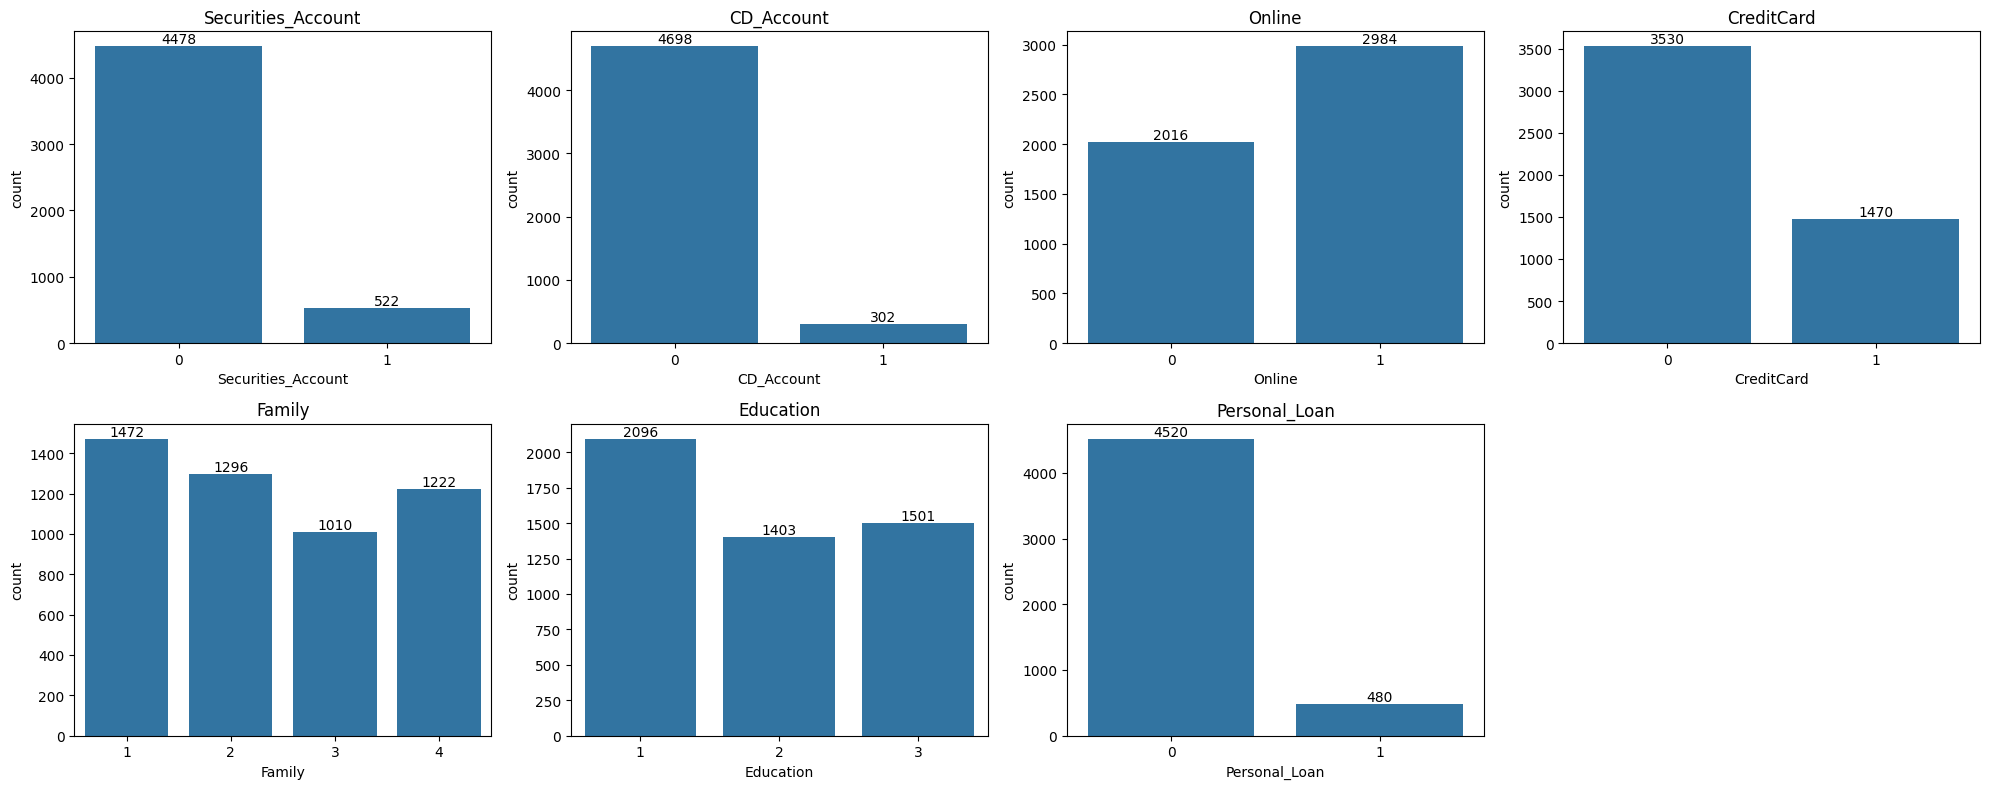

In [16]:
count_plot(df, cat_attrs)

### Observation  - Categorical Attributes/Column
* **Securities_Account**
     - 522 customers only have Securities account with the bank and 4478 don't have it.
* **CD_Account**
     - 302 customers only have CD account with the bank and 4698 don't have it.
* **Online**
     - 2984 customers only have online account with the bank and 2016 don't have it.
* **CreditCard**
     - 1470 customers only have credit card with other bank (excluding All life Bank) and 3530 don't have it.
* **Family**
     - Customers family size varies from 1 to 4. 1472 customers with family size is the highest and 1010 with family size with 3 is the lowest group.
* **Education**
      - 2096 customers have completed Undergrad. 1403 completed Graduate and the remaining 1501 has Advance/Professional degree.
* **Personal_Loan**
      - 480 customers accepted Personal Loan offered last year campaign and remaining 4520 didn't accept it. 


Bivariate analysis for Personal_Loan


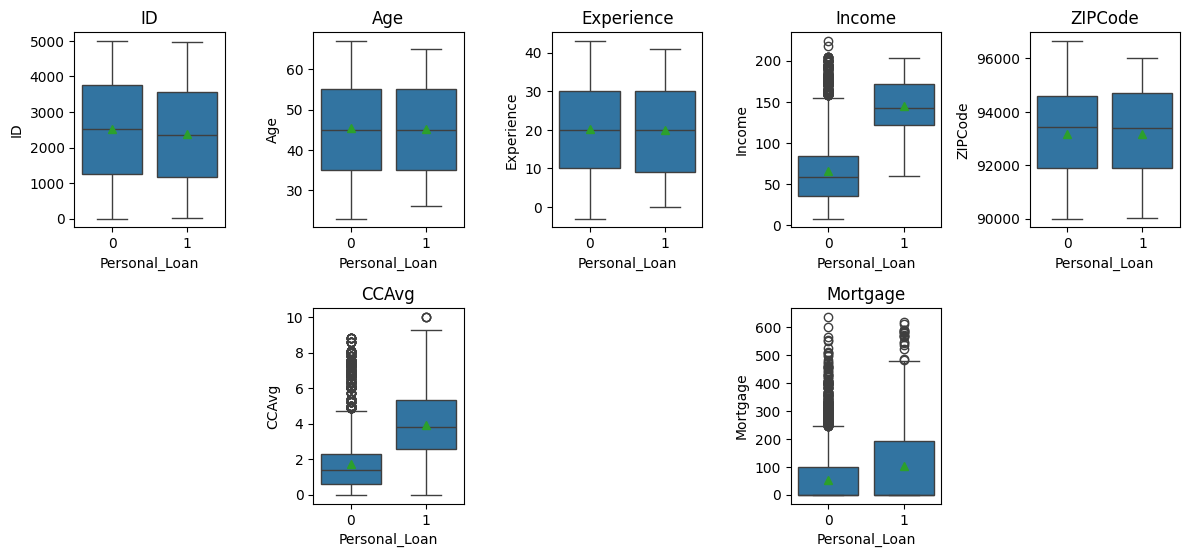

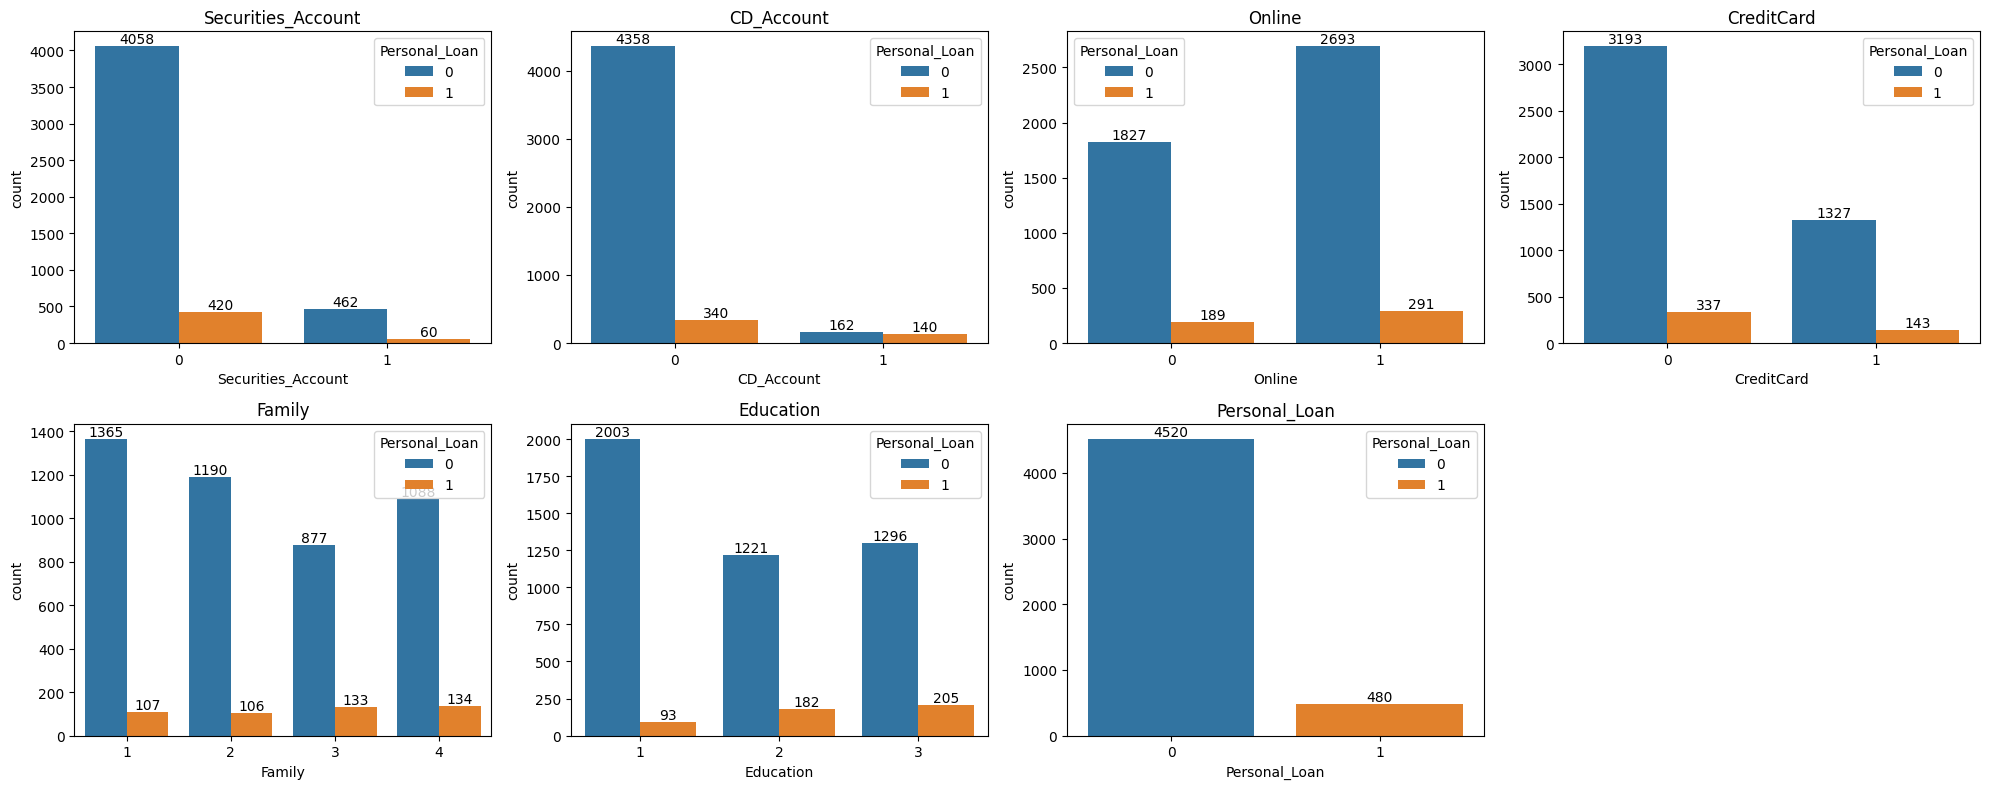

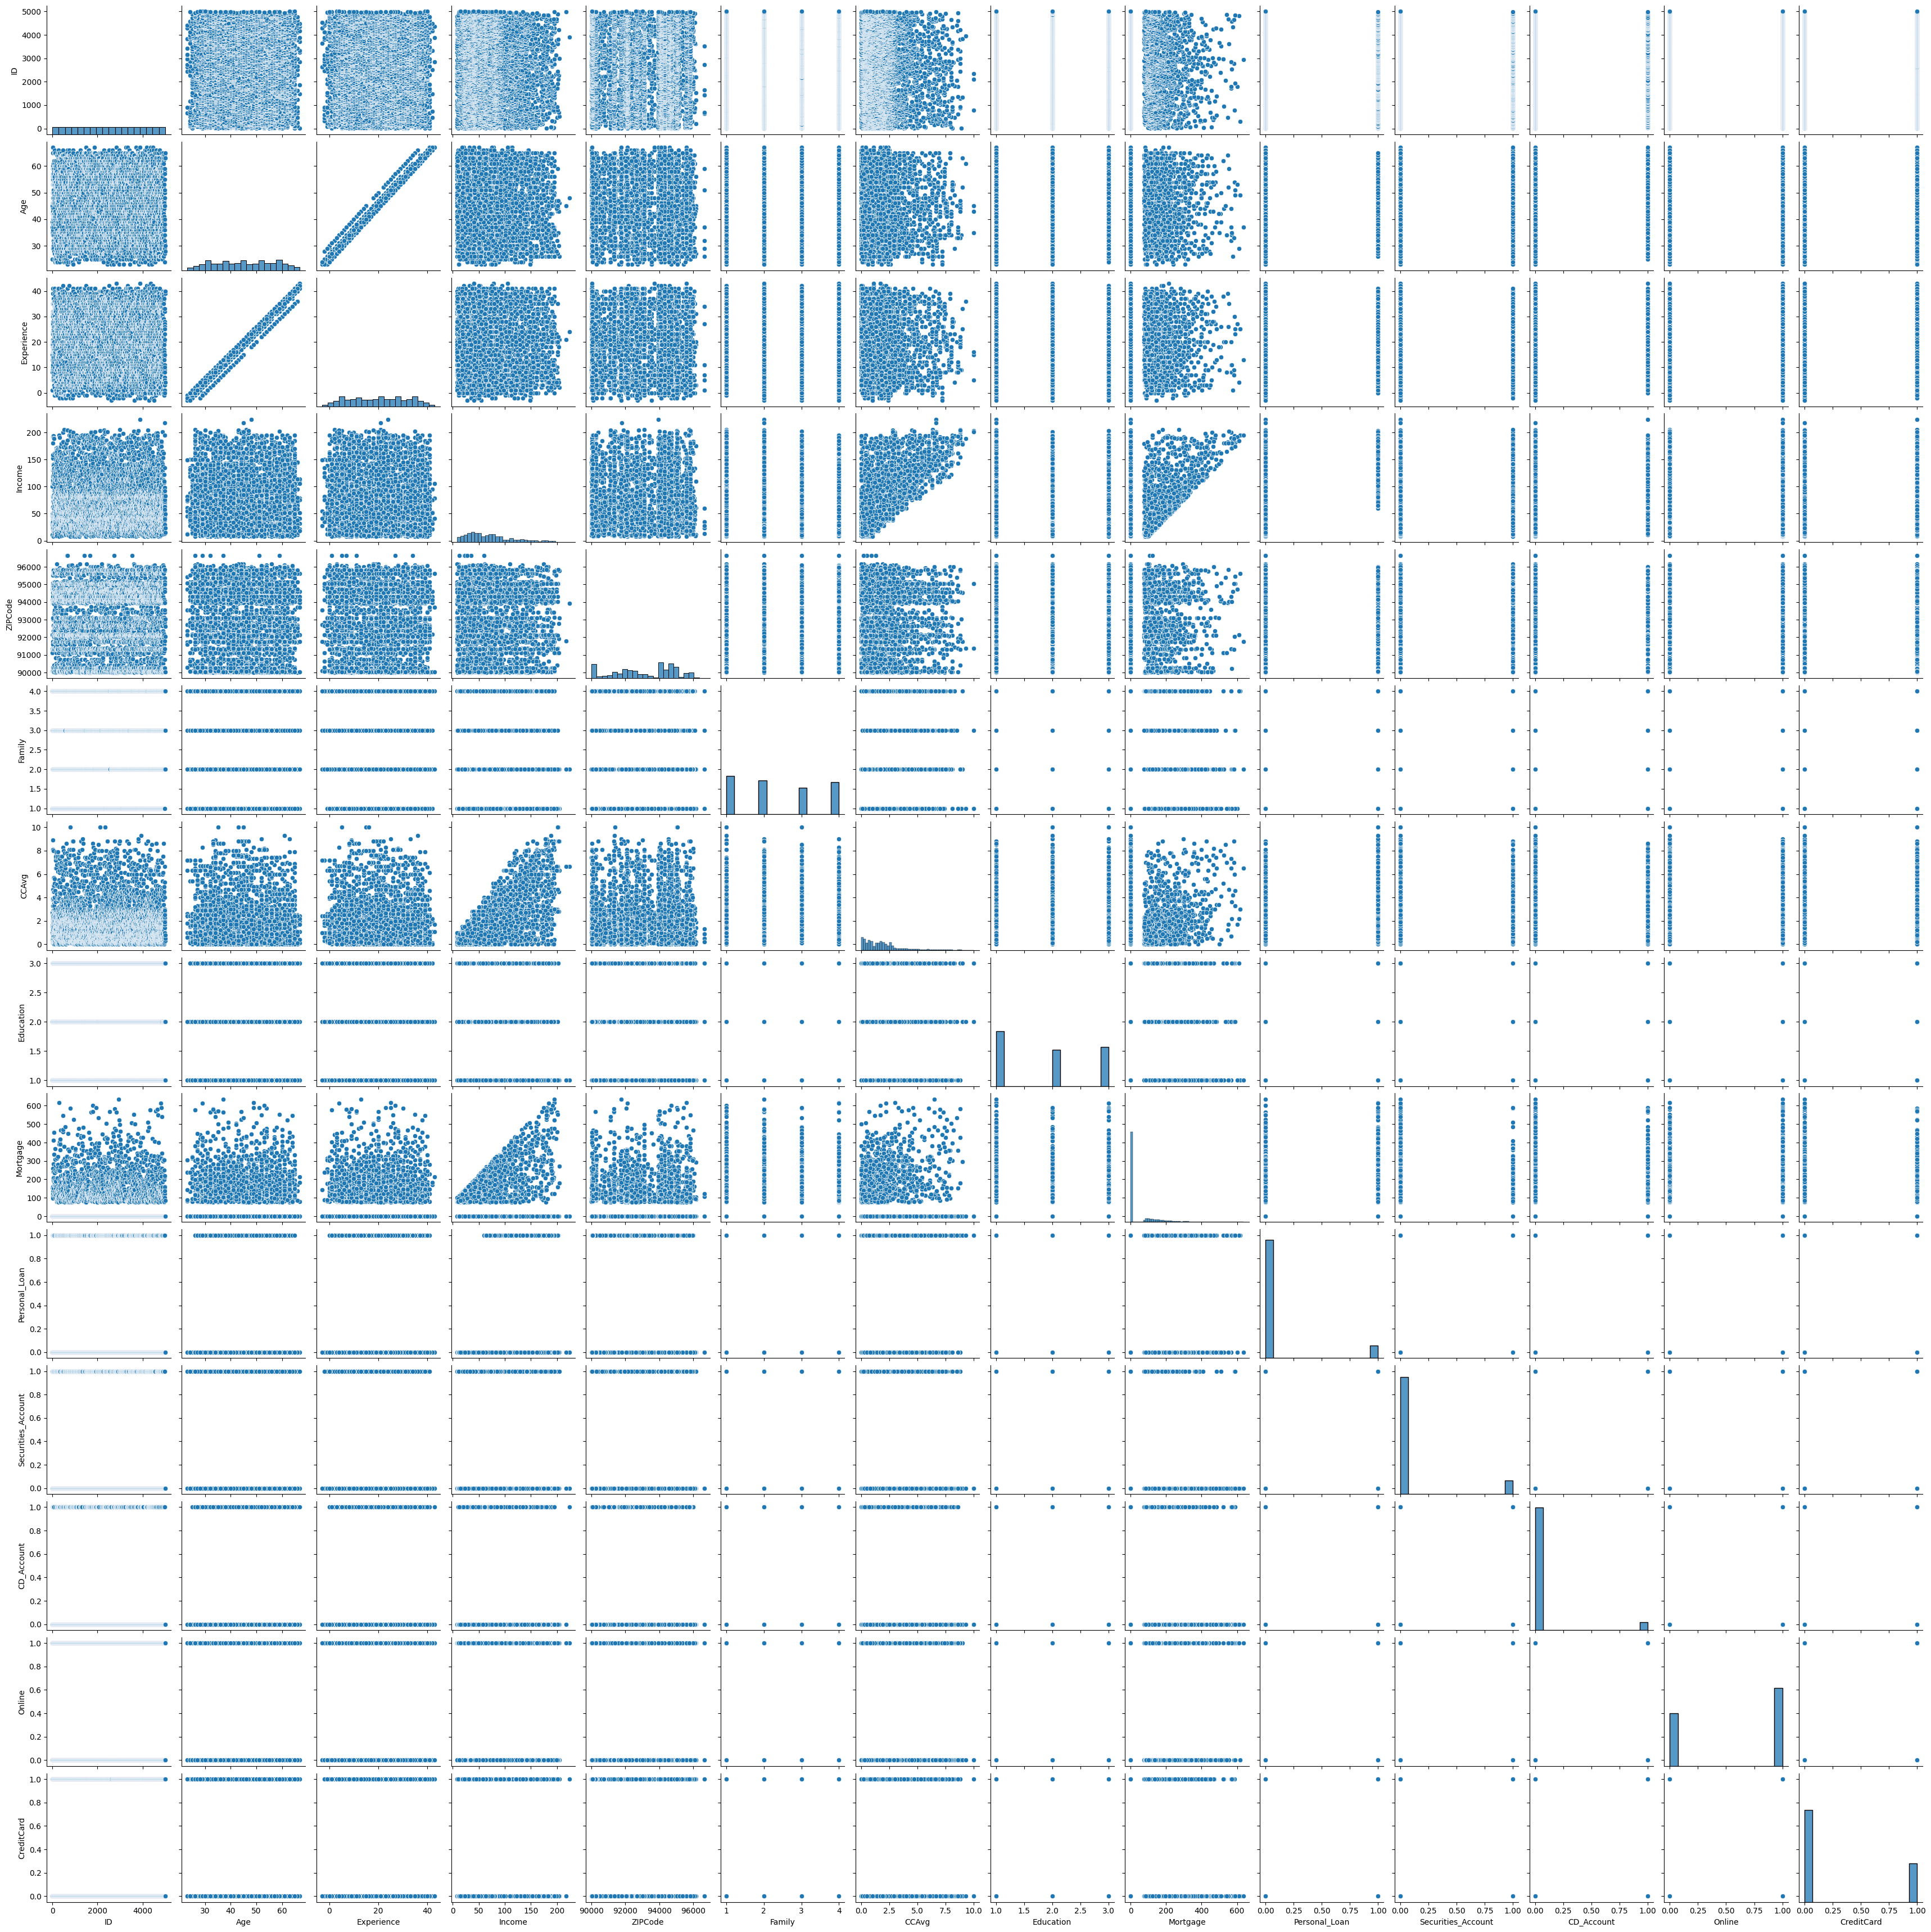

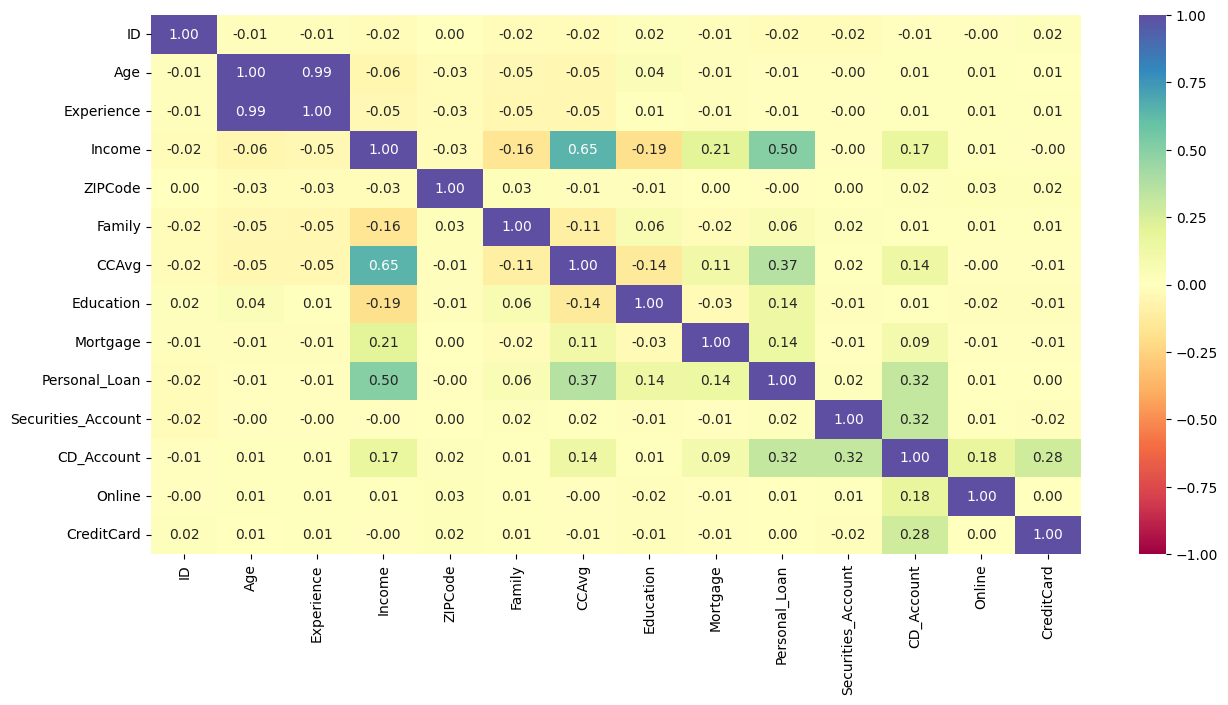

In [17]:
# bivariate_analysis_wrt_target plot box plot against target attribute for numeric continuous attributes/columns
# Input:
# df -> dataframe
# target_col -> target attribute
# cat_attr -> list of categorical attributes
def bivariate_analysis_wrt_target(df, target_col, cat_attr = []):
    print("Bivariate analysis for {}".format(target_col))
    columns = df.select_dtypes(include='number').columns.tolist()
    plt.figure(figsize=(12, 8))
    
    for i, col in enumerate(columns):
        if (col != target_col) & (col not in cat_attr):
            plt.subplot(3, 5, i + 1)
            sns.boxplot(x = target_col, y = col, data = df,showmeans=True)
            plt.tight_layout()
            plt.title(col)
    plt.show()


# count_plot2 plot histogram using customized bins against target attribute for numeric continuous attributes/columns
# Input:
# df -> dataframe
# target_col -> target attribute
# cat_attr -> list of categorical attributes
# num_of_bin -> number of bin for histogram
def count_plot2(df, cat_attrs, target_col, num_of_bin):
    df_cp = df.copy()
    plt.figure(figsize=(20, 3))
    for i, col in enumerate(cat_attrs):
        min_left = df_cp[col].min()
        max_left = df_cp[col].max()
        step = math.floor((max_left - min_left)/ num_of_bin)
        bins = np.arange(min_left, max_left , step)
        bins[0] = bins[0] - 1
        bins[-1] = bins[-1] + 1
        #print(bins)
        labels = []
        for j in range(len(bins)):
            if j + 1 < len(bins):
                labels.append('{} - {}'.format(bins[j], bins[j + 1]))
        #print(labels)
        binned_col = '{} (Binned)'.format(col)
        df_cp[binned_col] = pd.cut(df_cp[col], bins=bins, labels=labels)
        
        plt.subplot(1, len(cat_attrs), i + 1)
        ax = sns.countplot(data=df_cp, x=binned_col, hue=target_col)
        #ax = df_cp.set_index(binned_col).plot(kind='bar', stacked=True)
        for container in ax.containers:
            ax.bar_label(container)
        
        plt.tight_layout()
        plt.title(col)

    plt.show()

   
bivariate_analysis_wrt_target(df, y_colmn, cat_attrs)

count_plot(df, cat_attrs, y_colmn)


# Pari plot
sns.pairplot(df)
plt.show()

# Correlation Matrix
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

columns = df.columns.tolist()
columns.remove(y_colmn)
#print(columns)


### Observation  - Bi-variate/multi-variate analysis

* 9% customer accepts the Personal Loan
* Customers with age group 35-55 years old purchased Personal Loan.
* Customers with experience 10-30 years old purchased Personal Loan.
* Customers with high income tend to purchased Personal Loan.
* Customers with CCAvg/credit card spending tend to purchased Personal Loan.
* Customers with high mortgage tend to purchased Personal Loan.
* 60 customer with Security account with the bank purchased Personal Loan.
* 140 customer with CD account with the bank purchased Personal Loan.
* Customer with online account with the bank purchased more Personal Loan than offline account.
* Customer with no credit card except the bank purchased more Personal Loan than offline account.
* Customer with family size 3 or 4 purchased more Personal Loan.
* Customer with higher degrees purchased more Personal Loan.
* Income, CCAvg, Securities_Account have good positive correlation with Personal Loan.
* Age and Experience has a strong positive correlation.
* Income and CCAvg has high positive correlation.
* Income and Mortgage has a positive correlation. 


## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

In [18]:
def find_whisker(data):
    """Calculates whisker for outliers in a dataset using the IQR method.

    Args:
        data (pd.Series or np.array): The dataset to analyze.

    Returns:
        float, float: lower and upper bound of outlier whisker in the dataset.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

def show_value_count_with_percentage(df):
    counts = df.value_counts()
    percentages = df.value_counts(normalize=True) * 100
    value_counts_df = pd.DataFrame({'counts': counts, 'percentages (%)': percentages})
    print(value_counts_df)


In [19]:
lower_wsk, upper_wsk = find_whisker(df['Mortgage'])
num_outliers = df[(df['Mortgage'] < lower_wsk) | (df['Mortgage'] > upper_wsk)][["Mortgage"]].count()
print(f"Total number of outliers {num_outliers}")

df_mort = df[df["Mortgage"] > 0][["Mortgage"]].copy()
lower_wsk, upper_wsk = find_whisker(df_mort)
num_outliers = df_mort[(df_mort['Mortgage'] < lower_wsk) | (df_mort['Mortgage'] > upper_wsk)][["Mortgage"]].count()
print(f"Total number of outliers after filtering 0 mortgage {num_outliers}")

print("Personal Loan Accept for customers with a mortgage")
show_value_count_with_percentage(df[df["Mortgage"] > 0][["Personal_Loan"]])

print("Personal Loan Accept for customers without a mortgage")
show_value_count_with_percentage(df[df["Mortgage"] == 0][["Personal_Loan"]])


Total number of outliers Mortgage    291
dtype: int64
Total number of outliers after filtering 0 mortgage Mortgage    70
dtype: int64
Personal Loan Accept for customers with a mortgage
               counts  percentages (%)
Personal_Loan                         
0                1370        89.076723
1                 168        10.923277
Personal Loan Accept for customers without a mortgage
               counts  percentages (%)
Personal_Loan                         
0                3150        90.987868
1                 312         9.012132


1. ***What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?***
- The distribution of mortgage has a right skewed distribution with 291 outliers.
- Among customers with no mortgage, only 9% accepts personal loan.
- Among customers with any mortgage, only 10% accepts personal loan. 
- Customers with high mortgage (> 100K) tend to accept Personal Loan. However, exceptions/outliers also exist.
- 3462 customers have no mortgage and 1538 customers have mortgage. If we exclude 0 mortgage customers, it also has a right skewed distribution with 70 outliers and the mean shifted to near about 190K. It means that average mortgage is near 190K dollar for customers who has a mortgage. 

   

2. ***How many customers have credit cards?***
- 1470 customers only have credit card with other bank (excluding All life Bank) and 3530 don't have it.

3. ***What are the attributes that have a strong correlation with the target attribute (personal loan)?***
- Income has strong positive correlation with Personal Loan
- CCAvg and CD_Account have also positive correlations. 

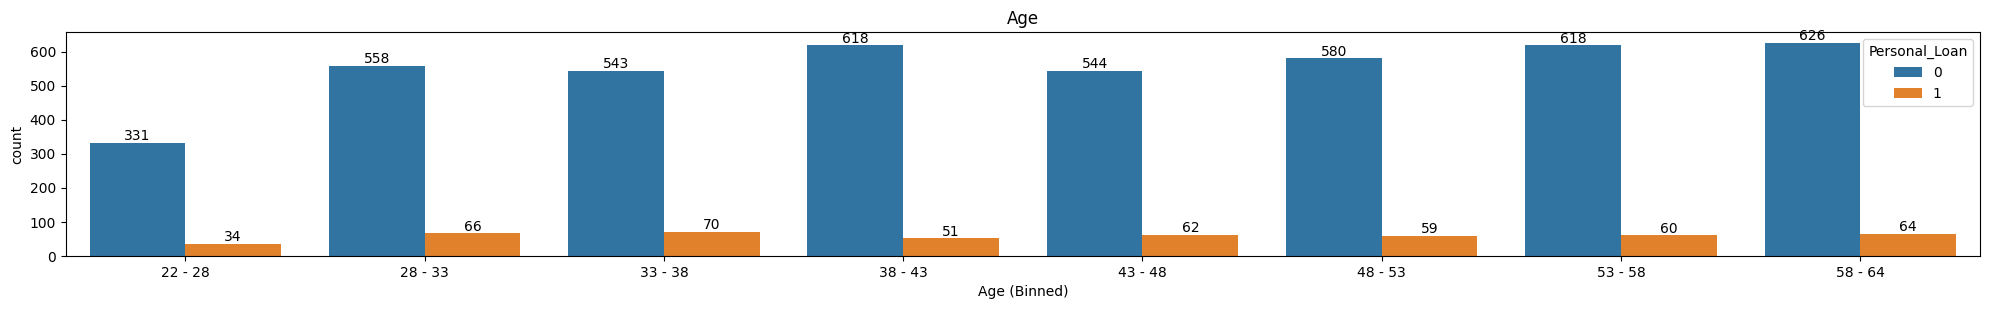

In [20]:
cat_attr_bin = ["Age"]
#stacked_hist(df, y_colmn, cat_attr_bin)
count_plot2(df, cat_attr_bin, y_colmn, 8)


4. ***How does a customer's interest in purchasing a loan vary with their age?***
- Customers accepting Personal Loan have age varies from 35-55 years. However, Further categorizing age group shows that, customers with age 33-38 years old has more interest to purchase loan followed by age group 28-33 years and 53 - 58 years.

5. ***How does a customer's interest in purchasing a loan vary with their education?***
-  Customers with advance/Professional degress have more interest in purchasing loan following by customers having graduate and undergrad degree.

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

### Missing value treatment
There are no missing value. So no action needed. However, Experience column has some negative values.

#### Imputing median for negative experience 

In [21]:
# Checking Experience column
df['Experience'].describe().T

count    5000.000000
mean       20.104600
std        11.467954
min        -3.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

In [22]:
# Calculate the median of non-negative values in 'Experience'
median_non_negative = df['Experience'][df['Experience'] >= 0].median()

# Replace negative values in 'Experience' with the calculated median
df['Experience'] = np.where(df['Experience'] < 0, median_non_negative, df['Experience'])

# Print the modified DataFrame
df['Experience'].describe().T

count    5000.000000
mean       20.327600
std        11.253035
min         0.000000
25%        11.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

### Feature engineering (if needed)


In [23]:
# Dropping ID column
df.drop('ID', axis=1, inplace=True)
df.head()

Age  Experience  Income  ZIPCode  Family  CCAvg  Education  Mortgage  \
0   25         1.0      49    91107       4    1.6          1         0   
1   45        19.0      34    90089       3    1.5          1         0   
2   39        15.0      11    94720       1    1.0          1         0   
3   35         9.0     100    94112       1    2.7          2         0   
4   35         8.0      45    91330       4    1.0          2         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

#### Extracting city and state from ZIPCode

In [24]:
# Lookup state and city by ZIP Code. Return np.nan if no match found
# input: 
# ZIPCode: Zip code as integer 
def lookup_state_city_from_zip_code(zipcode):
    city = np.nan
    state = np.nan
    if (zipcode in zcdb):
        city, state = zcdb[zipcode].city, zcdb[zipcode].state 
    return city, state

def lookup_city_from_zip_code(zipcode):
    city = np.nan
    if (zipcode in zcdb):
        city = zcdb[zipcode].city 
    return city

def lookup_state_from_zip_code(zipcode):
    state = np.nan
    if (zipcode in zcdb):
        state = zcdb[zipcode].state 
    return state

#print(lookup_state_city_from_zip_code(92717))
# Step 1: Creating two columns: city and state in the dataframe by looking up zipcode
df['city'] = df['ZIPCode'].apply(lookup_city_from_zip_code)
df['state'] = df['ZIPCode'].apply(lookup_state_from_zip_code)
# Step 2: Checking if they are added
df.head()

Age  Experience  Income  ZIPCode  Family  CCAvg  Education  Mortgage  \
0   25         1.0      49    91107       4    1.6          1         0   
1   45        19.0      34    90089       3    1.5          1         0   
2   39        15.0      11    94720       1    1.0          1         0   
3   35         9.0     100    94112       1    2.7          2         0   
4   35         8.0      45    91330       4    1.0          2         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
0              0                   1           0       0           0   
1              0                   1           0       0           0   
2              0                   0           0       0           0   
3              0                   0           0       0           0   
4              0                   0           0       0           1   

            city state  
0       Pasadena    CA  
1    Los Angeles    CA  
2       Berkeley    CA  
3  San Francisco    CA  
4     Northridge    CA

In [25]:
# Step 3: Getting Info and found that few rows with city and state have missing value
df.info()
missing_data = df[pd.isnull(df["city"])]
#print(missing_data)
missing_data['ZIPCode'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   float64
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
 13  city                4966 non-null   object 
 14  state               4966 non-null   object 
dtypes: float64(2), int64(11), object(2)
memory usage: 586.1

92717    22
96651     6
92634     5
93077     1
Name: ZIPCode, dtype: int64

In [26]:
# Step 4: Manually finding the city and state for 92717, 96651,  92634, 93077
missing_city = {92717:'Irvine', 96651:'Lotus', 92634:'Fullerton', 93077: 'Ventura' }
missing_sate = {92717:'CA', 96651:'CA', 92634:'CA', 93077: 'CA'}

def lookup_city_from_zip_code_if_missing(zipcode):
    city = np.nan
    if (zipcode in zcdb):
        city = zcdb[zipcode].city
    elif (zipcode in missing_city):
        city = missing_city[zipcode]
        
    return city

def lookup_state_from_zip_code_if_missing(zipcode):
    state = np.nan
    if (zipcode in zcdb):
        state = zcdb[zipcode].state 
    elif (zipcode in missing_sate):
        state = missing_sate[zipcode]

    return state

df['city'] = df['ZIPCode'].apply(lookup_city_from_zip_code_if_missing)
df['state'] = df['ZIPCode'].apply(lookup_state_from_zip_code_if_missing)

df.info()
print("Missing value")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   float64
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
 13  city                5000 non-null   object 
 14  state               5000 non-null   object 
dtypes: float64(2), int64(11), object(2)
memory usage: 586.1

In [27]:
#count_plot(df, ['city', 'state'])
unique_values(df, 'state')
unique_values(df, 'city')

# Top N (=20) city by customers who accepted personal loan
N=20
print("\nTotal customer accepting personal loan by top {} city".format(N))
df_top_N = df[df['Personal_Loan'] == 1][["city"]].value_counts()[:N]
print("\n\033[4mcity\033[0m \033[4mTotal customer\033[0m")
print(df_top_N)

Total unique value 1 for attribute state

state  Total Count
CA    5000
Name: state, dtype: int64
Total unique value 243 for attribute city

city  Total Count
Los Angeles      375
San Diego        269
San Francisco    257
Berkeley         241
Sacramento       148
                ... 
Sausalito          1
Ladera Ranch       1
Sierra Madre       1
Tahoe City         1
Stinson Beach      1
Name: city, Length: 243, dtype: int64

Total customer accepting personal loan by top 20 city

city Total customer
city            
Los Angeles         38
Berkeley            27
San Diego           21
San Francisco       19
Palo Alto           16
La Jolla            15
Sacramento          13
Stanford            13
Santa Clara         12
Irvine              11
San Jose            11
Pasadena            10
Santa Barbara        8
Santa Cruz           7
Los Altos            6
Davis                6
Monterey             6
Huntington Beach     5
Oakland              5
Santa Clarita        5
dtype: int64


In [28]:
#Step 5:

# Dropping ZIPCode column
df.drop('ZIPCode', axis=1, inplace=True)
df.head()

Age  Experience  Income  Family  CCAvg  Education  Mortgage  Personal_Loan  \
0   25         1.0      49       4    1.6          1         0              0   
1   45        19.0      34       3    1.5          1         0              0   
2   39        15.0      11       1    1.0          1         0              0   
3   35         9.0     100       1    2.7          2         0              0   
4   35         8.0      45       4    1.0          2         0              0   

   Securities_Account  CD_Account  Online  CreditCard           city state  
0                   1           0       0           0       Pasadena    CA  
1                   1           0       0           0    Los Angeles    CA  
2                   0           0       0           0       Berkeley    CA  
3                   0           0       0           0  San Francisco    CA  
4                   0           0       0           1     Northridge    CA

### Observation
* All customers belong to California
* Los Angeles, San Diego, San Francisco, Berkeley, Sacramento are the top 5 city having most customers.
* Los Angeles, Berkeley, San Francisco, Palo Alto, La Jolla are the top 5 city having most customers accepted Personal Loan..

### Outlier detection and treatment (if needed)
* Income, CCAvg, Mortgage has outlier. However, customers with higher income, CCAvg, Mortgage tend to accept Personal Loan. Therefore, they provide information. Hence, no action taken for outlier.

### Preparing data for modeling

In [29]:
# Splitting Training and Testing dataset.
#Input:
# df -> dataframe to split
# test_size -> test size ratio. 1 - ration will be for training
# random_state -> radom state/seed
# is_stratify -> whether is stratified data or not
def get_train_test_split(df, target, test_size=.2, random_state=42, is_stratify=True):
    # Step 1: Dropping target attribute/Column
    print("data set Shape {}".format(df.shape))
   
    X = df.drop(columns=[target], axis=1)
    y = df[target].map(lambda x: classes.index(str(x)))
    
    # Step 2: Hot encoding of categorical attributes/Columns
    X = pd.get_dummies(
    X, X.select_dtypes(include=['object', 'category']).columns,
    drop_first=True,
    ).astype(float) 
    
    # Step 3: Splitting test and training data as per ration, random state, and stratification 
    if is_stratify == True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print("Training Shape {}, testing Shape {}".format(X_train.shape, X_test.shape))

    print('Total positive outcome in original data set {},  in train {}, test {}'.format(str(sum(y)), str(sum(y_train)), str(sum(y_test)))) 
    print('probabilty of positive outcome distribution in train {}%, test {}%'.format(sum(y_train)/X_train.shape[0] * 100, sum(y_test)/X_test.shape[0] * 100))
    
    return X_train, X_test, y_train, y_test

# plot_confusionmatrix generates a confusion matrix with heat map
# Input:
# y_test -> test labels
# y_pred -> predicted labels
# environment -> It is a environment/title for different type of classifications
# classes -> List of binary classes. For examples, for Personal [Not Accepted, Accepted], 0 -> Not Accepted, 1 -> Accepted of "Personal_Loan" column
def plot_confusionmatrix(y_test, y_pred, environment, classes):
    print('Confusion matrix for {}'.format(environment))
    cm = confusion_matrix(y_test,y_pred)

    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()
    
# get_accuracy generates a confusion matrix with performance evaluation metrics
# Input:
# y_test -> test labels
# y_pred -> predicted labels
# environment -> It is a environment/title for different type of classifications
# classes -> List of binary classes. For examples, for Personal [Not Accepted, Accepted], 0 -> Not Accepted, 1 -> Accepted of "Personal_Loan" column
def get_accuracy(y_test, y_pred, environment, classes):
    print('Performance evaluation for {}'.format(environment))
    
    plot_confusionmatrix(y_test, y_pred, environment, classes)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = fbeta_score(y_test, y_pred, beta=1)  
    f2score = fbeta_score(y_test, y_pred, beta=2)
    evaluation_metric = pd.DataFrame({"model": environment, "accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1score, "f2_score":f1score}, index=[0])
    print(evaluation_metric.T)
    return evaluation_metric

# get_accuracy_only generates performance evaluation metrics only
# Input:
# y_test -> test labels
# y_pred -> predicted labels
# environment -> It is a environment/title for different type of classifications
# classes -> List of binary classes. For examples, for Personal [Not Accepted, Accepted], 0 -> Not Accepted, 1 -> Accepted of "Personal_Loan" column
def get_accuracy_only(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = fbeta_score(y_test, y_pred, beta=1)  
    f2score = fbeta_score(y_test, y_pred, beta=2)
    evaluation_metric = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1score, "f2_score":f1score}
    return evaluation_metric
    
# buid_decisionTree creates and returns a decision tree instance, predict both training and test dataset 
# Input:
# X_train -> Training dataset
# y_train -> training labels 
# X_test -> testing dataset
# random_state -> random state
def buid_decisionTree(X_train,y_train, X_test, random_state=42):# buid_decisionTree creates and returns a decision tree instance, predict both training and test dataset 
    clf = tree.DecisionTreeClassifier(random_state=random_state)
    clf.fit(X_train,y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    return clf, y_train_pred, y_test_pred

# buid_decisionTree creates and returns a decision tree instance, predict both training and test dataset. This is used in prepruning 
# Input:
# X_train -> Training dataset
# y_train -> training labels 
# X_test -> testing dataset
# params -> Parameter to pass in a dictionary for pre pruning
# random_state -> random state
def buid_decisionTree_from_param(X_train,y_train, X_test, params, random_state=42):
    clf = tree.DecisionTreeClassifier(random_state=random_state)
    clf.set_params(**params)
    clf.fit(X_train,y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    return clf, y_train_pred, y_test_pred

# show_feature_importance plots the features with importance
# Input:
# clf -> decision tree instance
# feature_names -> list of the feature
# x_scale and y_scale for x and y scale to draw feature importance graph
def show_feature_importance(clf, feature_names, x_scale=12, y_scale=12):
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    
    df_feature = pd.DataFrame({'feature':feature_names[indices], 'importance': importances[indices]})
    df_feature_filtering_non_zero_importance = df_feature.sort_values(by='importance', ascending=False)
    df_feature_filtering_non_zero_importance = df_feature_filtering_non_zero_importance[df_feature_filtering_non_zero_importance['importance'] > 0]
    plt.figure(figsize=(x_scale, y_scale))
    plt.title("Feature Importances")
    sns.barplot(data=df_feature_filtering_non_zero_importance, y='feature', x='importance', orient='h', color="green")
    plt.xlabel("Relative Importance (Normalized)")
    plt.show()      
    
# show_tree plots and prints tree
# Input:
# clf -> decision tree instance
# feature_names -> list of the feature
# print_tree -> whether print tree in text format or not
# x_scale and y_scale for x and y scale to draw feature importance graph
def show_tree(clf, feature_names, print_tree=True, x_scale=12, y_scale=12):
    print("Total node count {}, and max depth {}".format(clf.tree_.node_count, clf.tree_.max_depth))
    
    plt.figure(figsize=(20,20))
    tree.plot_tree(clf,feature_names=feature_names, class_names=classes,filled=True)
    plt.show()
    if print_tree == True:
        print(tree.export_text(clf,feature_names=feature_names, class_names=classes))

    show_feature_importance(clf,feature_names, x_scale=12, y_scale=12)


In [30]:
random_state = 1
test_split = .3
is_stratify = True
X_train, X_test, y_train, y_test = get_train_test_split(df, y_colmn, test_split,  random_state, is_stratify)


data set Shape (5000, 14)
Training Shape (3500, 253), testing Shape (1500, 253)
Total positive outcome in original data set 480,  in train 336, test 144
probabilty of positive outcome distribution in train 9.6%, test 9.6%


### Any other preprocessing steps (if needed)
* Hot encoding was performed in all categorical string/object variable in dataset before splitting to tranining and test. Therefore, no other preprocessing steps are needed.
  

### Observations - After splitting training and testing
* 70% of dataset has been assigned to training and 30% to testing with random state 1 and with stratification
* Distribution of positive labels are almost same percentage in both training and testing dataset. 


## Model Building

### Building Default Decision Tree
* We will build a decission tree and predict Personal_Loan.
* Later we will use Pre and Post Pruning to optimize model. 

### Model Building

Total node count 115, and max depth 15


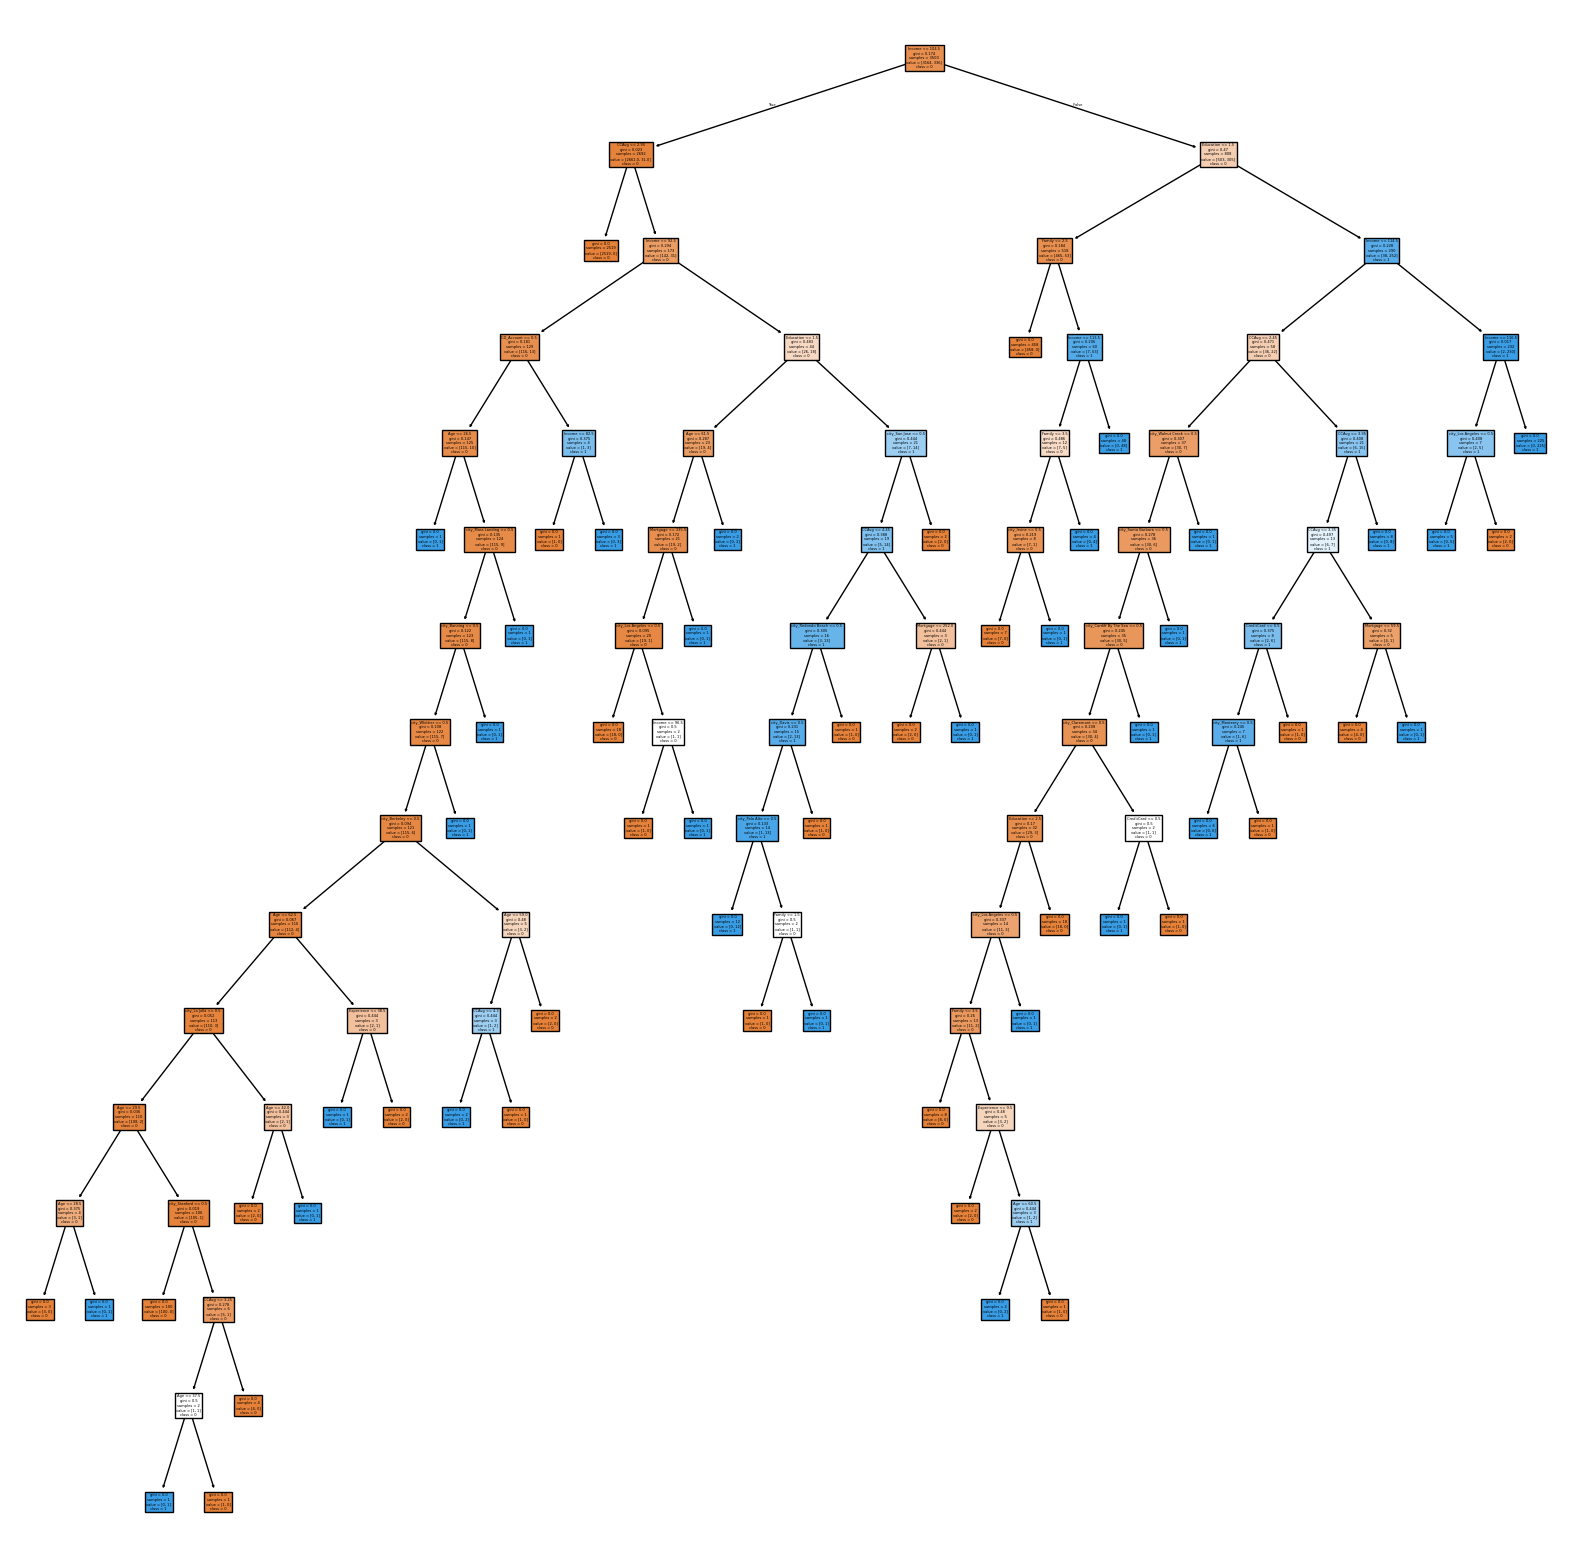

|--- Income <= 104.50
|   |--- CCAvg <= 2.95
|   |   |--- class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 92.50
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- Age <= 26.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  26.50
|   |   |   |   |   |--- city_Moss Landing <= 0.50
|   |   |   |   |   |   |--- city_Banning <= 0.50
|   |   |   |   |   |   |   |--- city_Whittier <= 0.50
|   |   |   |   |   |   |   |   |--- city_Berkeley <= 0.50
|   |   |   |   |   |   |   |   |   |--- Age <= 62.50
|   |   |   |   |   |   |   |   |   |   |--- city_La Jolla <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- city_La Jolla >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- Age >  62.50
|   |   |   |   |   |   |   |   |   |   |--- Experience <= 38.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |

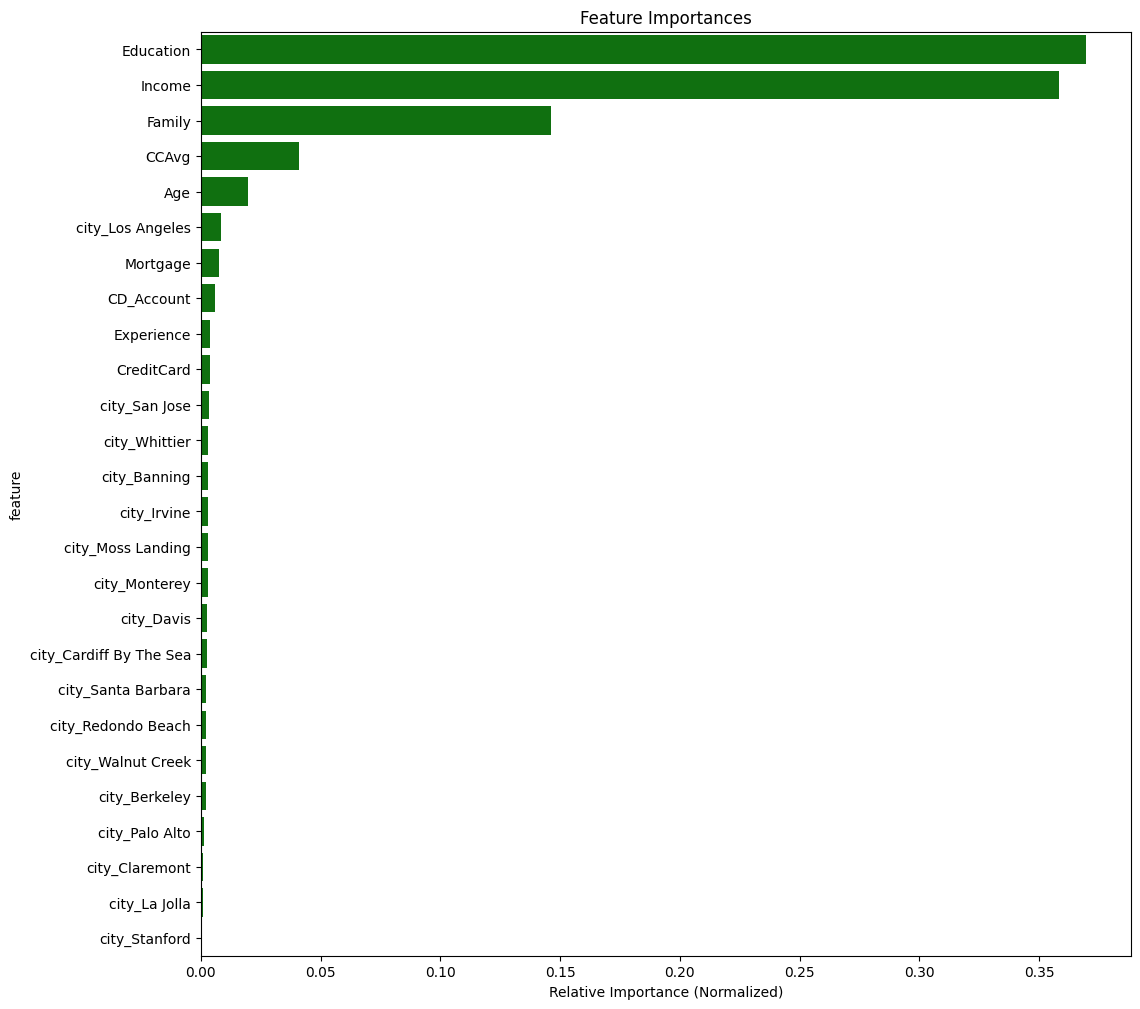

In [31]:
# Defining DecisionTreeClassifier
clf, y_train_pred, y_test_pred = buid_decisionTree(X_train,y_train, X_test, random_state)
show_tree(clf, X_train.columns, True)

#### Observation
* Default decision tree has 115 node and its max depth is 15.
* Education, Income, Family, CCAvg, Age, city_los Angeles are the top most importance features in the decision tree.

### Model Evaluation Criterion

* We will use Confusion matrix to find True Positive, True Negative, False Positive, and False Negative.
    - True positive (TP) denotes the number of correctly classified positive samples.
    - True negative (TN) represents the number of correctly classified negative samples.
    - False positive (FP) denotes the number of samples incorrectly classified as positive.
    - False negative (FN) denotes the number of samples incorrectly classified as negative.
* Accuracy, Precision, Recall, and harmonic mean of precision and recall, e.g., F1 and F2 score have been used in model's performance evaluation.
  
     \begin{equation*}
Accuracy =
{\frac{TP + TN} {TP + TN + FP + FN}}
\end{equation*}
     \begin{equation*}
Recall =
{\frac{TP} {TP + FN}}
\end{equation*}
     \begin{equation*}
Precission =
{\frac{TP} {TP + FP}}
\end{equation*}
   \begin{equation*}
F_{\beta} =
{(1 + \beta^{2}) . \frac{Precission . Recall} {(\beta^{2} . Precission) + Recall}}
\end{equation*}

* Accuracy will not give the correct measure if test dataset is imbalance. Therefore, other metrics, like precission, recall, F scores are helpful along with it.
  


Performance evaluation for DT Train
Confusion matrix for DT Train


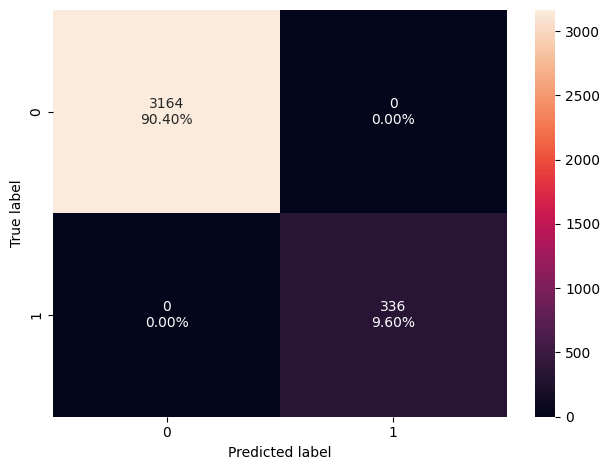

                  0
model      DT Train
accuracy        1.0
precision       1.0
recall          1.0
f1_score        1.0
f2_score        1.0
Performance evaluation for DT Test
Confusion matrix for DT Test


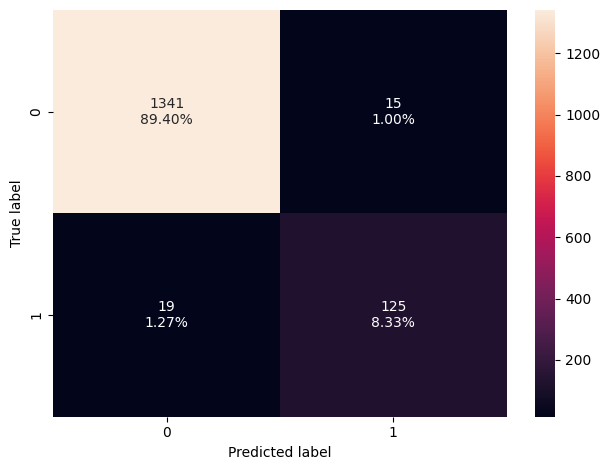

                  0
model       DT Test
accuracy   0.977333
precision  0.892857
recall     0.868056
f1_score   0.880282
f2_score   0.880282


In [32]:
acc_dt_train = get_accuracy(y_train, y_train_pred, 'DT Train', classes)
acc_dt_test = get_accuracy(y_test, y_test_pred, 'DT Test', classes)

#### Observation
* Default decision tree model has 100% accuracy, recall, precission, and fscores in predicting train dataset.
* It has also accuracy, recall, precission, and fscores in predicting test dataset.
* As model has 100% training accuracy, it indicates the model is overfitted or bias to traingset.
* Performance optimization requires to avoid overfitting.

## Model Performance Improvement

### Pre Pruning

Pre Pruning
DT Param of best model by GridSearchCV: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 1, 'splitter': 'best'}
Total node count 65, and max depth 7


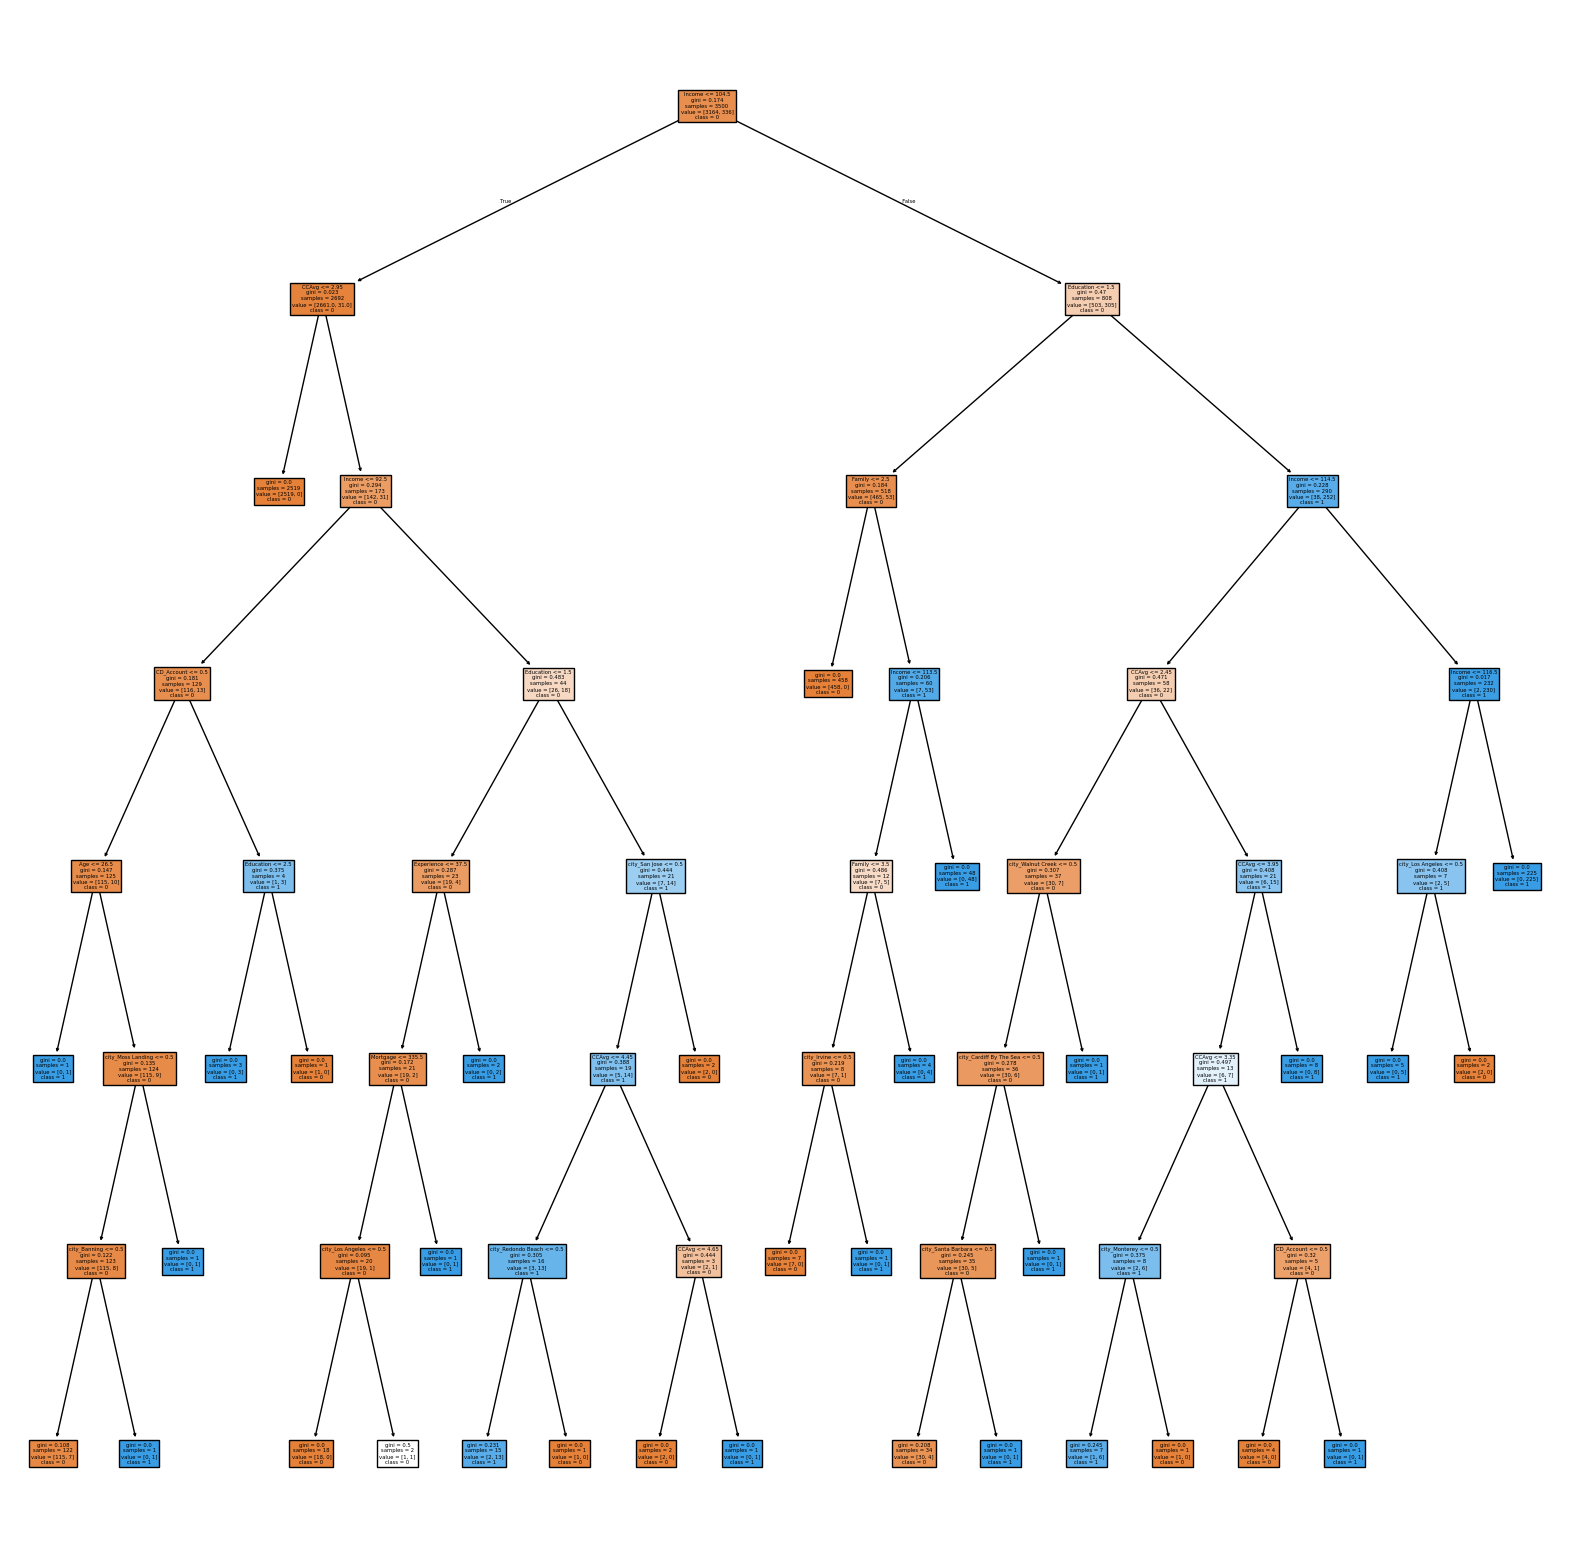

|--- Income <= 104.50
|   |--- CCAvg <= 2.95
|   |   |--- class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 92.50
|   |   |   |--- CD_Account <= 0.50
|   |   |   |   |--- Age <= 26.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  26.50
|   |   |   |   |   |--- city_Moss Landing <= 0.50
|   |   |   |   |   |   |--- city_Banning <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- city_Banning >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- city_Moss Landing >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- CD_Account >  0.50
|   |   |   |   |--- Education <= 2.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Education >  2.50
|   |   |   |   |   |--- class: 0
|   |   |--- Income >  92.50
|   |   |   |--- Education <= 1.50
|   |   |   |   |--- Experience <= 37.50
|   |   |   |   |   |--- Mortgage <= 335.50
|   |   |   |   |   |   |--- city_Los Angeles <= 0.50
|   |   |   |   |   |   |   |--- c

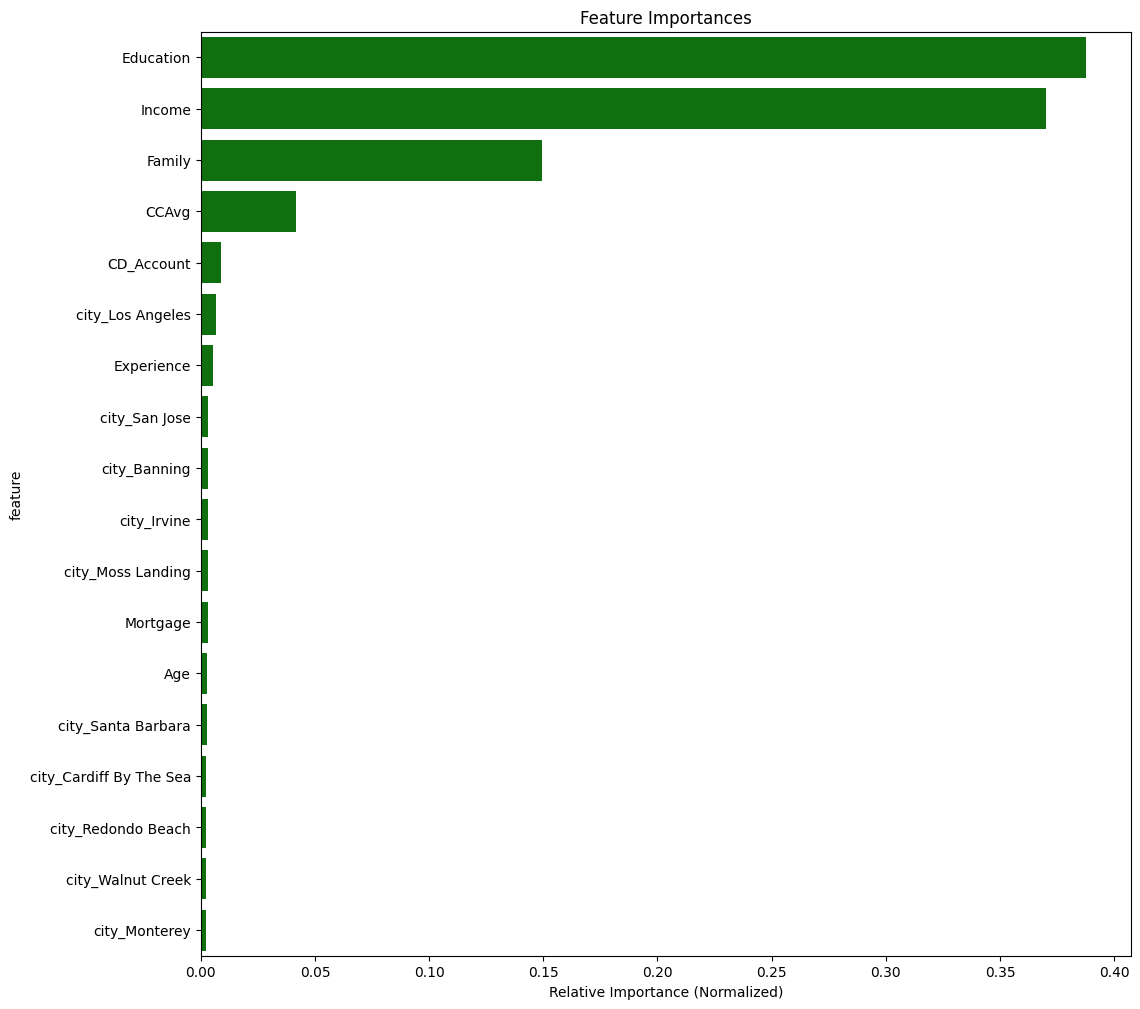

Performance evaluation for DT Train pre prune
Confusion matrix for DT Train pre prune


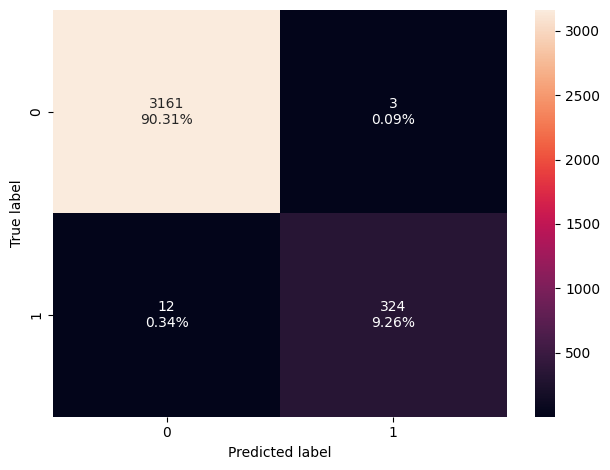

                            0
model      DT Train pre prune
accuracy             0.995714
precision            0.990826
recall               0.964286
f1_score             0.977376
f2_score             0.977376
Performance evaluation for DT Test pre prune
Confusion matrix for DT Test pre prune


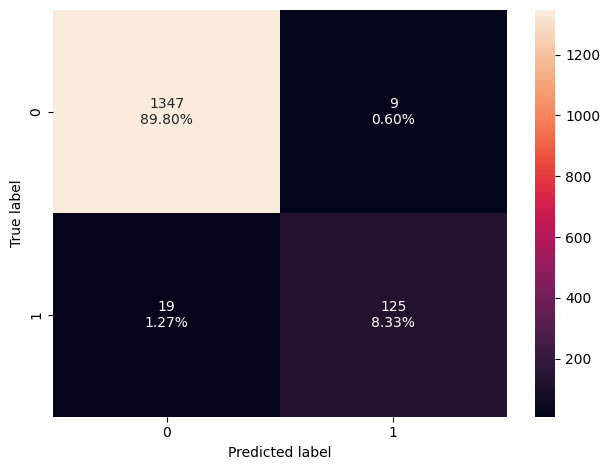

                           0
model      DT Test pre prune
accuracy            0.981333
precision           0.932836
recall              0.868056
f1_score            0.899281
f2_score            0.899281


In [33]:
## Pre pruning
#Parameter setting/Configuration of model
print("Pre Pruning")
params = {'max_depth': np.arange(1, X_train.shape[1], 3),
         'splitter': ["best", "random"],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

# get_best_method_by_grid_search find the best model by gradient decent method using different parameters in the model 
# Input
# clf -> classifier model
# X_train -> training dataset
# y_train -> training label
# params -> parameters as dictionary used for the pruning and best model search
# scoring -> scoring metric to compare models in gradient search
# cv -> cross validation fold in gradient search 
def get_best_method_by_grid_search(clf, X_train, y_train, params, scoring, cv=5):
    gcv = GridSearchCV(estimator=clf, param_grid=params, scoring=scoring, cv=cv)
    gcv.fit(X_train,y_train)
    best_model = gcv.best_estimator_
    print("DT Param of best model by GridSearchCV: {}".format( best_model.get_params()))
    return best_model

    
# get_best_method_by_grid_search find the best model by iterative method using different parameters in the model 
# Input
# clf -> classifier model
# X_train -> training dataset
# y_train -> training label
# params -> parameters as dictionary used for the pruning and best model search
# scoring -> scoring metric to compare models in gradient search
# random_state -> random state/seed
def get_best_method_by_param(clf, X_train, y_train, X_test, params, score, random_state=42):
    from sklearn.model_selection import ParameterGrid
    best_model = None
    best_metric_diff = float('inf')
    for param in list(ParameterGrid(params)):
        c, y_train_pred_pre_interim, y_test_pred_pre_interim = buid_decisionTree_from_param(X_train,y_train, X_test, param, random_state=random_state)
        metric_train = get_accuracy_only(y_train, y_train_pred_pre_interim)[score]
        metric_test = get_accuracy_only(y_test, y_test_pred_pre_interim)[score]
        metric_diff = abs(metric_train - metric_test)
        if metric_diff < best_metric_diff:
            best_metric_diff = metric_diff
            best_model = c
    print("DT Param of best model by iterative building : {}".format( best_model.get_params()))        
    return best_model

# recall has been used to compare models with different parameter in gradient search
clf_best_after_pre_pruning = get_best_method_by_grid_search(clf, X_train, y_train, params, 'recall')

clf_best_after_pre_pruning.fit(X_train,y_train)
y_train_pred_pre_prune = clf_best_after_pre_pruning.predict(X_train)
y_test_pred_pre_prune = clf_best_after_pre_pruning.predict(X_test)

show_tree(clf_best_after_pre_pruning, X_train.columns, True)
acc_dt_train_pre = get_accuracy(y_train, y_train_pred_pre_prune, 'DT Train pre prune', classes)
acc_dt_test_pre = get_accuracy(y_test, y_test_pred_pre_prune, 'DT Test pre prune', classes)


#### Observation
* Pre pruning finds a best decision tree model that has 65 nodes, and its max depth is 7.
* Education, Income, Family, CCAvg, CD_Account, city_los Angeles are the top most importance features in the decision tree.
* Pre prunned model has high train and test data predicting accuracy, and other scores.
* Model is simple, and generic 

### Post Pruning
* Cost-Complexity Pruning
    - Post-pruning, specifically cost-complexity pruning, aims to prevent overfitting by simplifying the decision tree after it's fully grown. 
* Alpha's Role
    - Alpha acts as a penalty for model complexity, meaning a higher alpha value encourages more pruning, resulting in a simpler tree. 

In [34]:
# Post Pruning
#Step 1: Calculating alphas
path = clf.cost_complexity_pruning_path(X_train, y_train)
#print(pd.DataFrame(path))
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Step2: For each alpha,  we build a model and append to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf_post_pruning = tree.DecisionTreeClassifier(random_state=random_state, ccp_alpha=ccp_alpha)
    clf_post_pruning.fit(X_train, y_train)
    clfs.append(clf_post_pruning)

# Deleting the last element of clfs and alphas as it refers to the tree with root.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]    
#print(len(clfs), len(ccp_alphas))

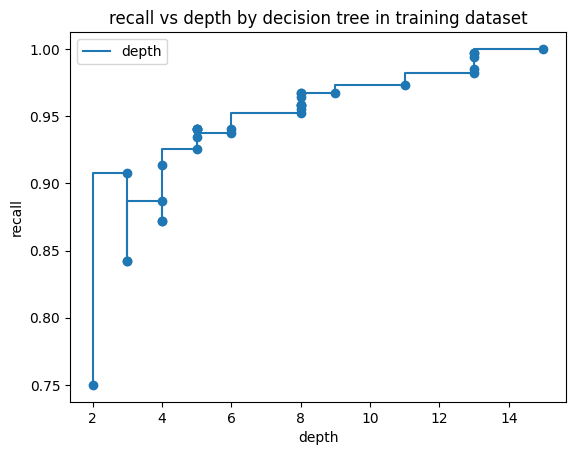

In [35]:
# Max depth vs recall
depth = []
recall = []
for clf in clfs:
    y_train_pred_pre_prune_depth = clf.predict(X_train)
    depth.append(clf.tree_.max_depth)
    recall.append(recall_score(y_train, y_train_pred_pre_prune_depth))

plt.scatter(depth,recall)
plt.plot(depth,recall,label='depth',drawstyle="steps-post")
plt.legend()
plt.xlabel('depth')
plt.ylabel('recall')
plt.title('recall vs depth by decision tree in training dataset')
plt.show()

#### Observation
* Recall increases with the depth of the tree.

32 32


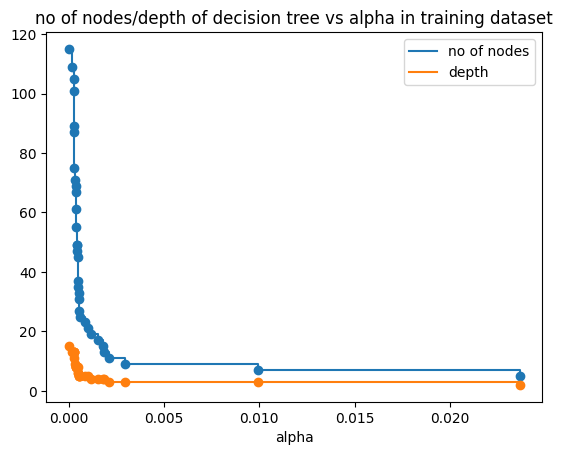

In [36]:
node_counts = [clf.tree_.node_count for clf in clfs]
#print(node_counts)
depth = [clf.tree_.max_depth for clf in clfs]
print(len(ccp_alphas), len(node_counts))
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.xlabel('alpha')
plt.title('no of nodes/depth of decision tree vs alpha in training dataset')
plt.show()

#### Observation
* Higher alpha means simpler tree with few nodes/depth.
* We saw after aplpha value = .01, both no of nodes and depth remain constant.

In [37]:
# Initialise the subplot function using number of rows and columns

# draw_performance_graphs_against_alpha draw graph/plot of performance metric against alpha and return the best model by all performance metics
# Input
# clfs -> model list
# X_train -> training dataset
# y_train -> training labels
# X_test -> testing dataset 
# y_test -> testing label
# ccp_alphas -> list of alphas
def draw_performance_graphs_against_alpha(clfs, X_train, y_train, X_test, y_test, ccp_alphas):
    best_model = {}
    performance_metric = ['accuracy', 'recall', 'precision', 'f1_score', 'f2_score']
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5, top=4)
    
    for metric in performance_metric: 
        train_acc = []
        test_acc = []
        # the first tree has alpha 0 /complex treee
        for c in clfs:
            y_train_pred_post_prune = c.predict(X_train)
            y_test_pred_post_prune = c.predict(X_test)
            if metric.lower() == 'accuracy':
                train_acc.append(accuracy_score(y_train, y_train_pred_post_prune))
                test_acc.append(accuracy_score(y_test, y_test_pred_post_prune))
            elif metric.lower() == 'recall':
                train_acc.append(recall_score(y_train, y_train_pred_post_prune))
                test_acc.append(recall_score(y_test, y_test_pred_post_prune))
            elif metric.lower() == 'precision':
                train_acc.append(precision_score(y_train, y_train_pred_post_prune))
                test_acc.append(precision_score(y_test, y_test_pred_post_prune))
            elif metric.lower() == 'f1_score':
                train_acc.append(fbeta_score(y_train, y_train_pred_post_prune, beta=1))
                test_acc.append(fbeta_score(y_test, y_test_pred_post_prune, beta=1))
            elif metric.lower() == 'f2_score':
                train_acc.append(fbeta_score(y_train, y_train_pred_post_prune, beta=2))
                test_acc.append(fbeta_score(y_test, y_test_pred_post_prune, beta=2))
            else:
                print('No evaluation metric found')
        
        i = performance_metric.index(metric)    
        ax = plt.subplot(3, 2, i + 1)

        #print(ccp_alphas, train_acc)
        ax.scatter(ccp_alphas,train_acc)
        ax.scatter(ccp_alphas,test_acc)
        ax.plot(ccp_alphas,train_acc,label='train_{}'.format(metric),drawstyle="steps-post")
        ax.plot(ccp_alphas,test_acc,label='test_{}'.format(metric),drawstyle="steps-post")
        ax.legend()
        ax.set_title('{} vs alpha'.format(metric))
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)

        # finding the best model
        best_model[metric] = clfs[np.argmax(test_acc)]
        
    plt.tight_layout()
    plt.show()

    return best_model

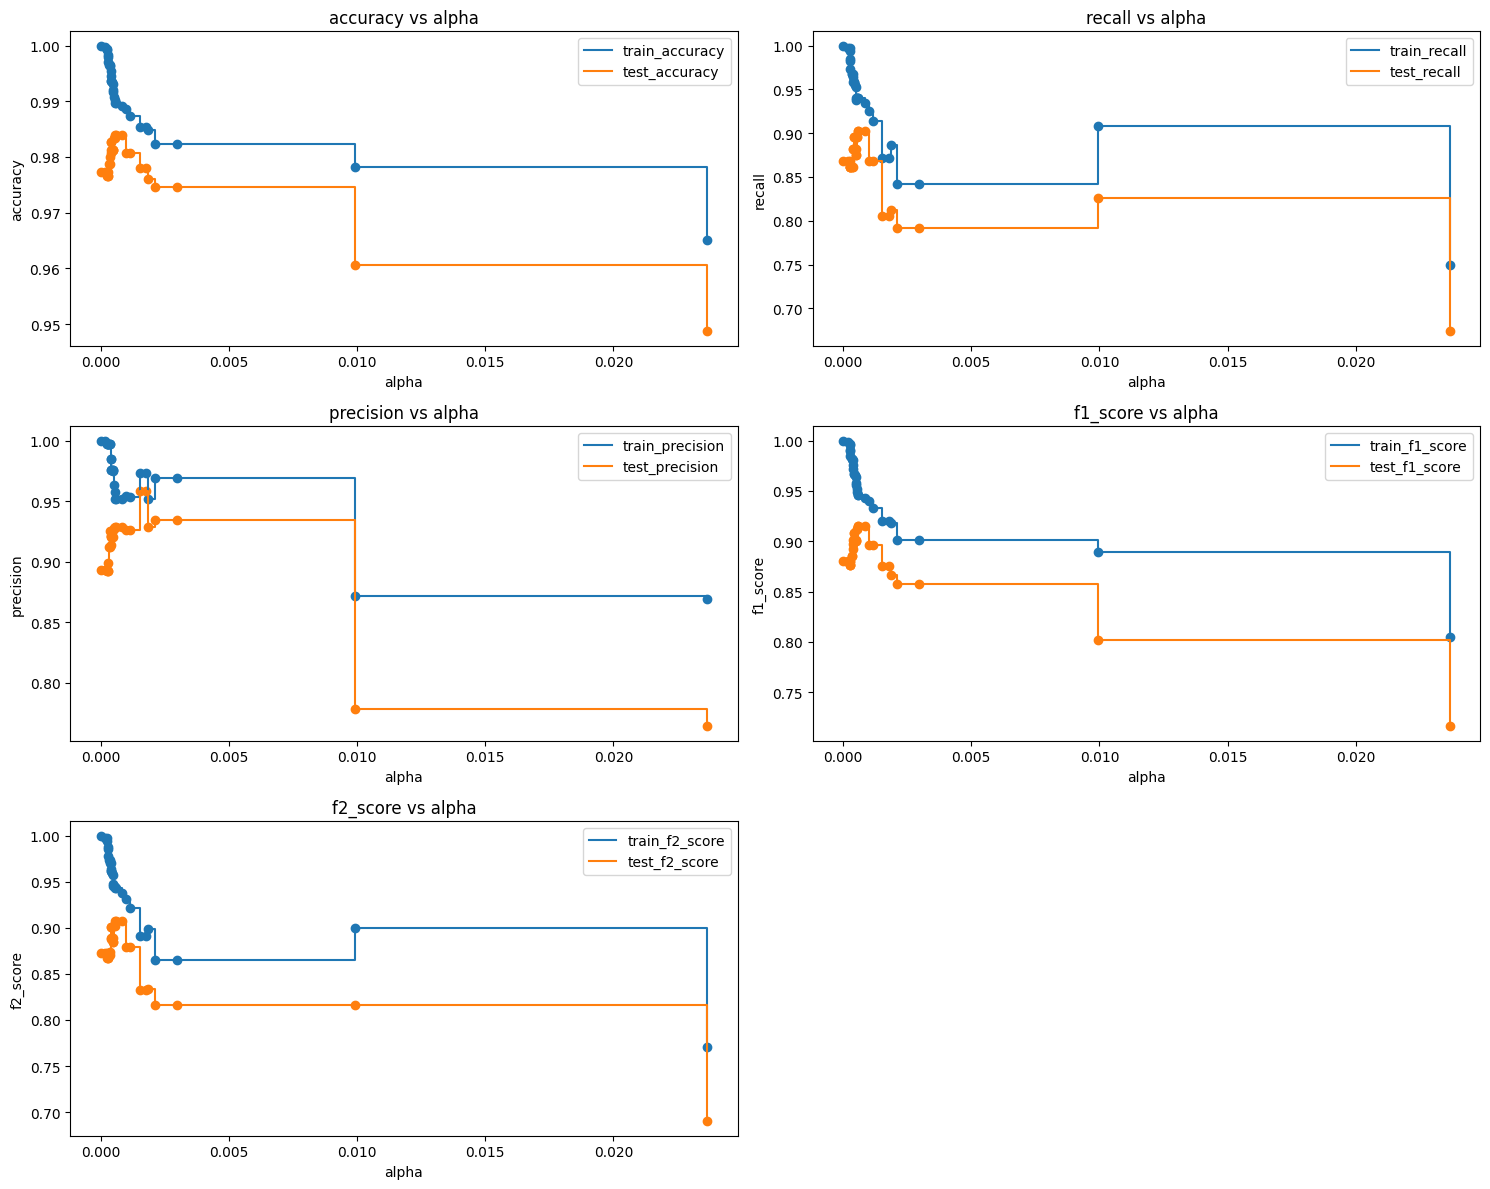

In [38]:
best_model = draw_performance_graphs_against_alpha(clfs, X_train, y_train, X_test, y_test, ccp_alphas)

#print(best_model)

#### Observation
* For all performance metrics, we see a stable line of both testing and training at alpha= 0.010.
* We can select best post pruning model with alpha= 0.010.

Total node count 7, and max depth 3


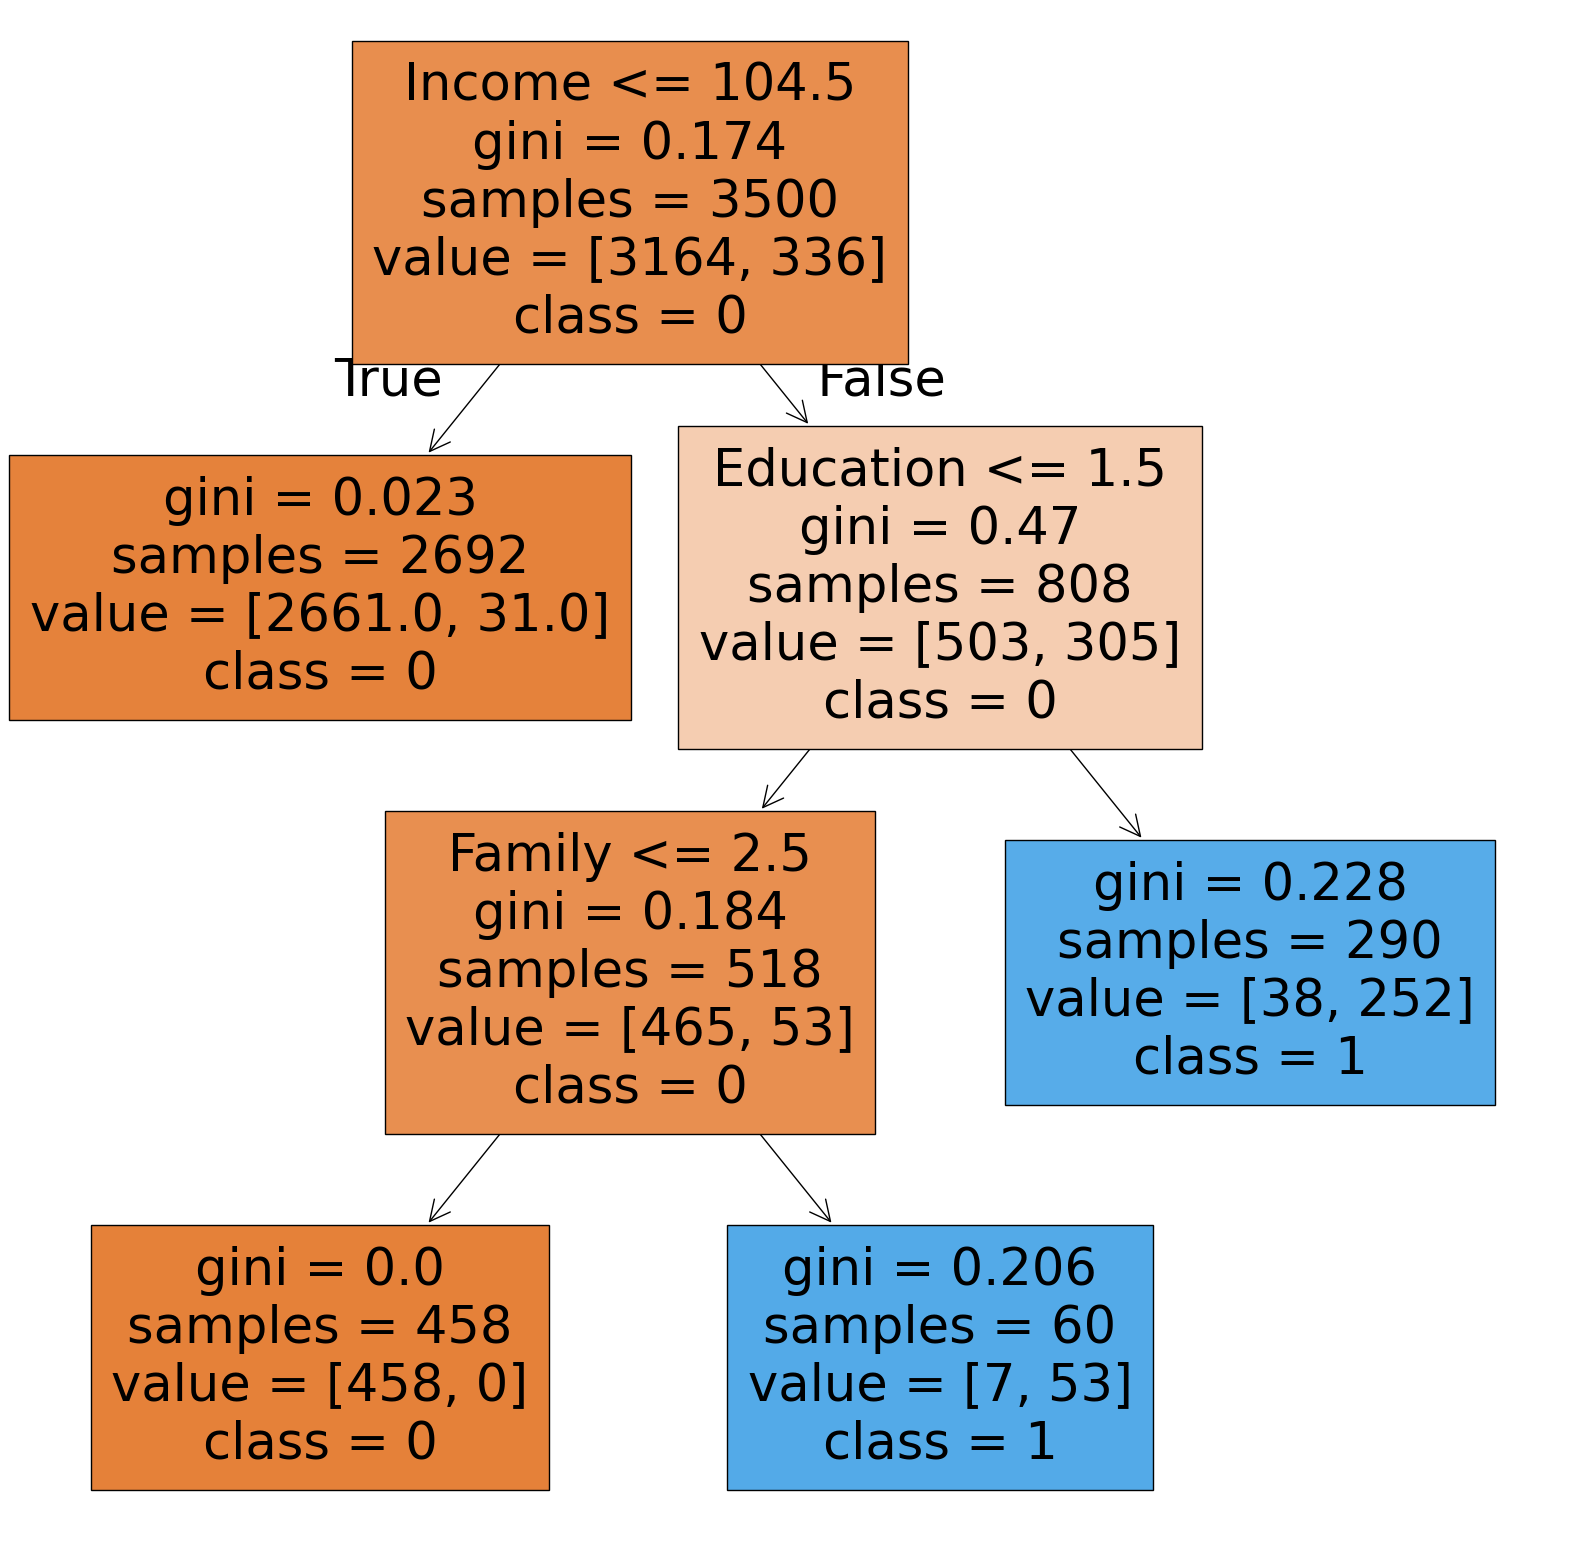

|--- Income <= 104.50
|   |--- class: 0
|--- Income >  104.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- class: 0
|   |   |--- Family >  2.50
|   |   |   |--- class: 1
|   |--- Education >  1.50
|   |   |--- class: 1



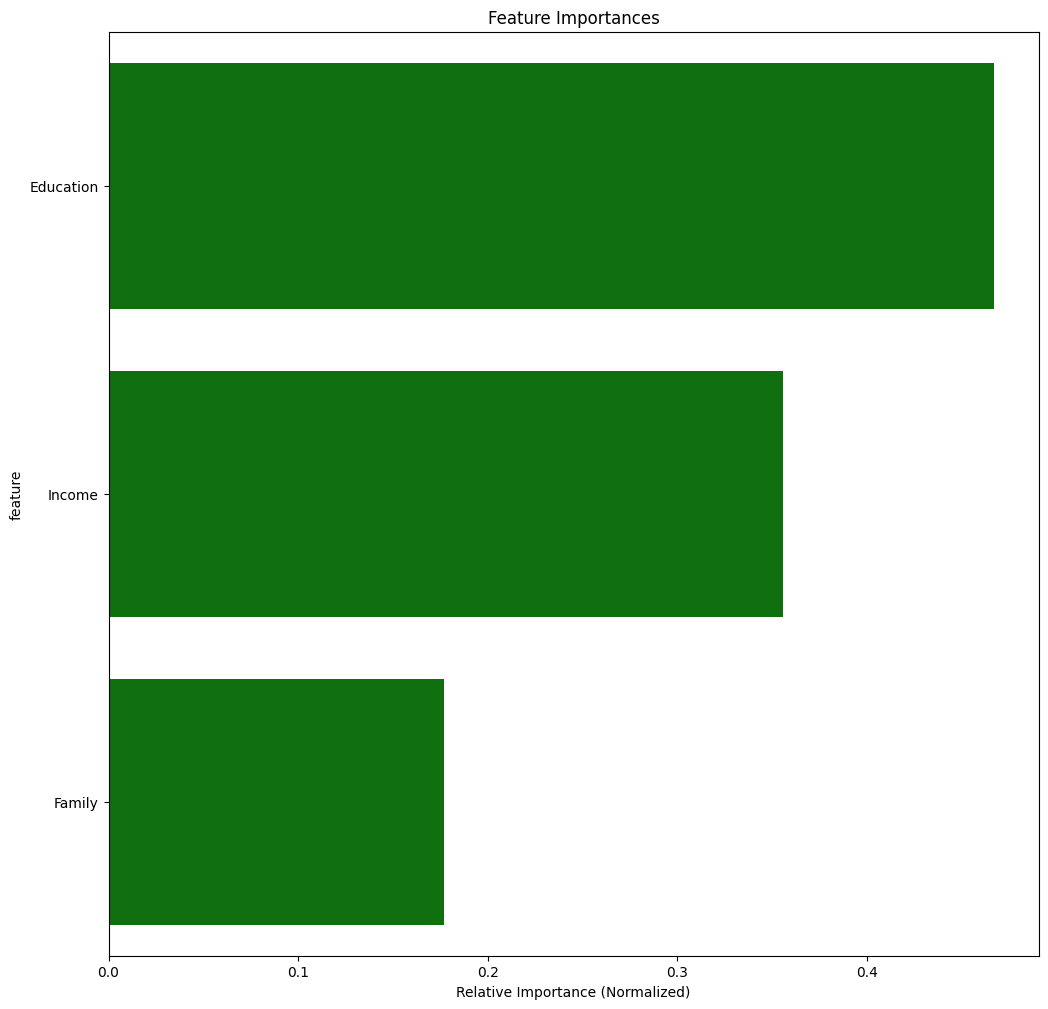

Performance evaluation for DT Train post prune
Confusion matrix for DT Train post prune


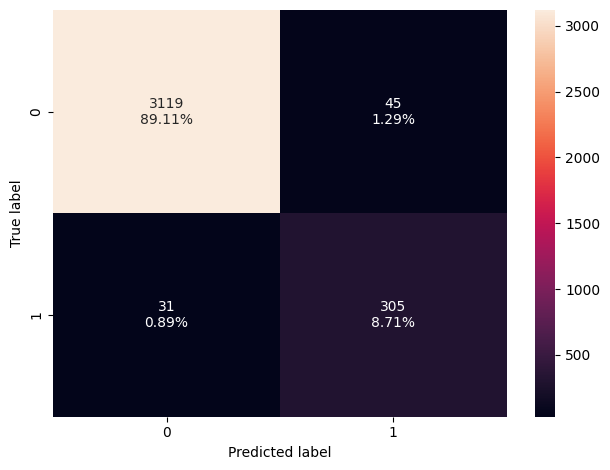

                             0
model      DT Train post prune
accuracy              0.978286
precision             0.871429
recall                0.907738
f1_score              0.889213
f2_score              0.889213
Performance evaluation for DT Test post prune
Confusion matrix for DT Test post prune


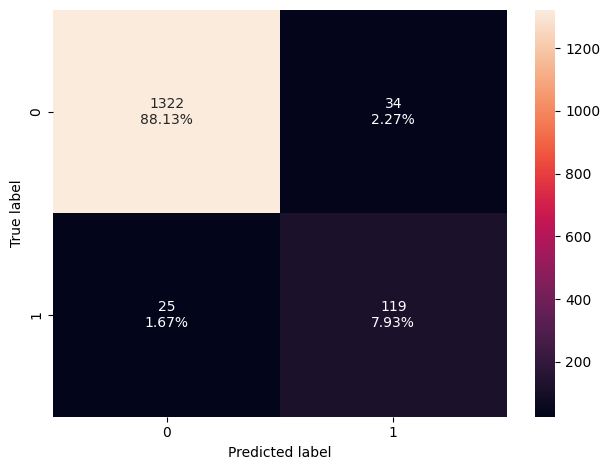

                            0
model      DT Test post prune
accuracy             0.960667
precision            0.777778
recall               0.826389
f1_score             0.801347
f2_score             0.801347


In [39]:
# Selecting the best tree on basis of f1_score

clf_post_prune_best = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=0.010)
clf_post_prune_best.fit(X_train,y_train)
y_train_pred_post_prune_best = clf_post_prune_best.predict(X_train)
y_test_pred_post_prune_best = clf_post_prune_best.predict(X_test)

show_tree(clf_post_prune_best, X_train.columns, True, 1,1)
acc_dt_train_post = get_accuracy(y_train, y_train_pred_post_prune_best, 'DT Train post prune', classes)
acc_dt_test_post = get_accuracy(y_test, y_test_pred_post_prune_best, 'DT Test post prune', classes)

#### Observation
* Post pruning finds a best decision tree model at alpha = .010 that has 7 nodes, and its max depth is 3.
* Education, Income, Family the most importance features in the decision tree.
* Post prunned model has high train data predicting accuracy but it degrades in the test data prediction.
* Other metrics (recall, precission) and scores (f1 and f2) degrades in test dataset prediction.
* Overall model is too simple and is not generic. 

## Model Performance Comparison and Final Model Selection

In [40]:
metric_columns = ['DT_Train', 'DT_Test', 'DT_Train Pre Prune', 'DT_Test Pre Prune', 'DT_Train Post Prune', 'DT_Test Post Prune']
accuracy_metric_for_all_trees = pd.concat([acc_dt_train, acc_dt_test, acc_dt_train_pre, acc_dt_test_pre, acc_dt_train_post, acc_dt_test_post])
accuracy_metric_for_all_trees.set_index("model").T

model      DT Train   DT Test  DT Train pre prune  DT Test pre prune  \
accuracy        1.0  0.977333            0.995714           0.981333   
precision       1.0  0.892857            0.990826           0.932836   
recall          1.0  0.868056            0.964286           0.868056   
f1_score        1.0  0.880282            0.977376           0.899281   
f2_score        1.0  0.880282            0.977376           0.899281   

model      DT Train post prune  DT Test post prune  
accuracy              0.978286            0.960667  
precision             0.871429            0.777778  
recall                0.907738            0.826389  
f1_score              0.889213            0.801347  
f2_score              0.889213            0.801347

#### Observation
* Accuracy
    * Default Decision tree model has 100% accuracy in training and high accuracy in testing.
    * Post pruned has 97% accuracy in training and 96% on testing.
    * Pre pruned Decision tree model also has 99.5% accuracy in training and high accuracy in testing. Its testing/prediction accuracy on test data is better than both default and post pruned decision tree.
* Precision
    * Default Decision tree model has 100% precision in training and 89% in testing.
    * Post pruned has 87% precision in training and 77% on testing.
    * Pre pruned Decision tree model also has 99% precision in training and high 93% in testing. Its testing/prediction precission on test data is better than both default and post pruned decision tree.
* Recall
    * Default Decision tree model has 100% recall in training and 86% in testing.
    * Post pruned has 90% recall in training and 82% on testing.
    * Pre pruned Decision tree model also has 96% recall in training and high 86% in testing. Its testing/prediction recall on test data is a little less default but better than post pruned decision tree.
* F1 and F2 score
    * Default Decision tree model has 100% f1 and f2 score in training and high score in testing.
    * Post pruned has 88% f1 and f2 score in training and 80% on testing.
    * Pre pruned Decision tree model also has 97% f1 and f2 score in training and 90% in testing. Its testing/prediction F scores on test data are better than both default and post pruned decision tree.


#### Final Model Selection
* Default decision tree model is generic but not simple
* Post pruned decision tree model is too simple but not generic
* Pre pruned decision tree balances them. Moreover, It beats all other model by performance metrics.
* Hence, we select pre pruned decision tree as the best model for out classification

In [41]:
# Using time.time()
start_time_time = time.time()
# Recommended model is pre-pruned model as it is simple with higer f score
print("Selecting a random test data point")
random_data_point = np.random.randint(X_test.shape[0])
print("Predicting {}th data point from test data set. Test data set has the total {} data points".format(random_data_point, X_test.shape[0]))
recommended_model = clf_best_after_pre_pruning
y_test_pred_recommended_model = recommended_model.predict(X_test[random_data_point : random_data_point + 1])
y_test_pred_prob_recommended_model = clf.predict_proba(X_test[random_data_point : random_data_point + 1])[0]
y_test_pred_prob = {}
for i in range(len(y_test_pred_prob_recommended_model)):
    y_test_pred_prob["{}/{}".format(i, classes[i])] = str(y_test_pred_prob_recommended_model[i] * 100) + "%"
    

#print(y_test_pred_prob_recommended_model)
#print("Predicting data point:")
#print(X_test[random_data_point : random_data_point + 1])

# Printing the attribute name bold
print("The attribute '\033[1m{}\033[0m' of the above data point has been predicted as \033[1m{}\033[0m with probability \033[1m{}\033[0m and it has original lebel \033[1m{}\033[0m".format(y_colmn, classes[y_test_pred_recommended_model[0]], y_test_pred_prob, classes[y_test.to_numpy()[random_data_point : random_data_point + 1][0]]))

end_time_time = time.time()
elapsed_time_time = end_time_time - start_time_time
print(f"Elapsed time to predict a data point by the model: \033[1m{elapsed_time_time:.2f}\033[0m seconds")


Selecting a random test data point
Predicting 1425th data point from test data set. Test data set has the total 1500 data points
The attribute 'Personal_Loan' of the above data point has been predicted as 0 with probability {'0/0': '98.84843982169392%', '1/1': '1.1515601783060923%'} and it has original lebel 0
Elapsed time to predict a data point by the model: 0.01 seconds


## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?
1. **Attactive Personal Loan Packages** with promotional/low interest can be offered to the following customers:
    * High income
    * High average monthly credit card usage
    * Having advance/Professional degree
    * large family size
    * Age between 35-55 years
    * Having CD Accounts
    * Living in cities like Los Angeles, Berkeley, San Francisco, Palo Alto, La Jolla in CA
3. **Complementary Personal Loan Package** can be offered to customers who has mortgage with the bank with incentive like waiving any late payment fee for mortgage, etc.  
4. **Onboarding new customers** and offer them Personal loan package if they are young, having advance/higher educational degree. Moreover, easy and custom repayment option can be attached to the loan packages based on income, family size. 
5. **Promote customers** with personal loan with free online account. 

___